# Loan Approval Classification — Notebook

Ce notebook effectue une Analyse Exploratoire des Données (Exploratory Data Analysis, EDA), le prétraitement, la sélection des features et propose différents modèles de classification des données.

## About Dataset
### 1. Data Source

This dataset is a synthetic version inspired by the original Credit Risk dataset on Kaggle and enriched with additional variables based on Financial Risk for Loan Approval data. SMOTENC was used to simulate new data points to enlarge the instances. The dataset is structured for both categorical and continuous features.

### 2. Metadata

Le dataset contient **45 000 observations** et **14 variables**.

#### Variables numériques (9)

| Variable | Description | Type |
|----------|-------------|------|
| `person_age` | Âge de la personne | Float |
| `person_income` | Revenu annuel | Float |
| `person_emp_exp` | Années d'expérience professionnelle | Integer |
| `loan_amnt` | Montant du prêt demandé | Float |
| `loan_int_rate` | Taux d'intérêt du prêt (%) | Float |
| `loan_percent_income` | Montant du prêt en % du revenu annuel | Float |
| `cb_person_cred_hist_length` | Durée de l'historique de crédit (années) | Float |
| `credit_score` | Score de crédit de la personne | Integer |
| **`loan_status`** *(target)* | **Statut d'approbation : 1 = approuvé, 0 = rejeté** | **Integer (binaire)** |

#### Variables catégorielles (5)

| Variable | Description | Modalités typiques |
|----------|-------------|-------------------|
| `person_gender` | Genre de la personne | Male, Female |
| `person_education` | Niveau d'éducation | High School, Bachelor, Master, Doctorate |
| `person_home_ownership` | Statut de propriété immobilière | Rent, Own, Mortgage, Other |
| `loan_intent` | Objectif du prêt | Education, Medical, Personal, Home Improvement, Debt Consolidation, Venture |
| `previous_loan_defaults_on_file` | Présence de défauts de paiement antérieurs | Yes, No |

### 3. Data Usage

The dataset can be used for multiple purposes:

- Exploratory Data Analysis (EDA): Analyze key features, distribution patterns, and relationships to understand credit risk factors.
- Classification: Build predictive models to classify the loan_status variable (approved/not approved) for potential applicants.
- Regression: Develop regression models to predict the credit_score variable based on individual and loan-related attributes.

Mind the data issue from the original data, such as the instance > 100-year-old as age.

This dataset provides a rich basis for understanding financial risk factors and simulating predictive modeling processes for loan approval and credit scoring.

## Contexte et objectifs

### Contexte

Ce notebook a pour but d'explorer un jeu de données de demandes de prêt, de préparer les données et d'entraîner des modèles de classification (Logistic Regression) pour prédire si un prêt est accordé (`loan_status`).

Étapes réalisées dans ce document :
- Chargement et vérification rapide des données
- Analyse exploratoire (EDA) des variables
- Rééquilibrage de la target (undersampling des classes majoritaires)
- Prétraitement (imputation, standardisation, encodage) via une pipeline
- Sélection simple de features (corrélation)
- Entraînement de pipeline avec GridSearchCV pour les différents modèles
- Évaluation et sauvegarde du modèle

### Objectifs

Les modèles de classification peuvent être évalués suivant plusieurs métriques. Les plus connues d'entre elles sont la précision et le rappel (precision and recall). Le F1-score est une combinaison des deux tel que :

$$F1 = \frac{2}{\frac{1}{\text{Precision}} + \frac{1}{\text{Recall}}}$$


$$F1 = 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}}$$

Où :
- **Precision** = $\frac{TP}{TP + FP}$ (proportion de prédictions positives correctes)
- **Recall** = $\frac{TP}{TP + FN}$ (proportion de vrais positifs détectés)
- TP = True Positives, FP = False Positives, FN = False Negatives

Le F1-score est la moyenne harmonique de la précision et du rappel, et atteint sa meilleure valeur à 1 (perfection) et sa pire à 0.


##### Pourquoi utilise-t-on le F1 score dans notre cas ?

Pour la banque, le plus important est une garantie de remboursement du crédit accordé. Il faut donc un être strict sur l'accord de celui-ci. On doit donc avoir un recall élevé.

En revanche, d'un point de vue morale, pour des questions d'attractivité de clientelle, la banque se doit aussi d'accorder des prêts.

On doit donc avoir un équilibre entre le recall et la précision : les deux sont importants et doivent afficher des scores élevés.


#### Objectif de F1 score

Quantitativement, on peut considérer notre modèle comme intéressant si le F1 est supérieur à 0.90, score pour lequel les recall et precision sont tous les deux hauts, garantissant à la fois une sécurité d'emprunt et une facilité d'acès à celui-ci.

$$F1 > 0.90$$

In [1]:
import os
import sys
import subprocess


def install_package(package):
    subprocess.check_call([sys.executable, "-m", "pip", "install", package])

# Liste des packages requis
required_packages = [
    'numpy', 
    'pandas', 
    'matplotlib', 
    'seaborn', 
    'scikit-learn',
    'scipy',
    'xgboost',
    'lightgbm',
    'torch',
    'gdown',
    'joblib'
]

for package in required_packages:
    try:
        if package == 'scikit-learn':
            __import__('sklearn')
        elif package == 'torch':
            __import__('torch')
        else:
            __import__(package)
    except ImportError:
        print(f"Installation de {package}...")
        install_package(package)

# Imports standards
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# Scipy
from scipy.stats import chi2_contingency, ttest_ind

# Scikit-learn
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    f1_score, precision_score, recall_score,
    precision_recall_curve, average_precision_score, PrecisionRecallDisplay,
    roc_curve, roc_auc_score, RocCurveDisplay
)

# Modèles de boosting
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# Pandas plotting
from pandas.plotting import scatter_matrix

%matplotlib inline


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.3.5 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/Users/amauryjanin/Library/Mobile Documents/com~apple~CloudDocs/Documents/IMT atlantique/TAF 2A/IA UE D/Projet AAA/.venv/lib/python3.11/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/Users/amauryjanin/Library/Mobile Documents/com~apple~CloudDocs/Documents/IMT atlantique/TAF 2A/IA UE D/Projet AAA/.venv/lib/python3.11/site-packages/traitlets/config/application.py"

### Chargement des données

Cette cellule charge le fichier CSV. Vérifiez le chemin `DATA_PATH`. Après le chargement, on affiche la dimension globale (`df.shape`) et un aperçu (`df.head()`). Si le fichier n'est pas trouvé, la cellule lève une erreur pour vous alerter.

In [2]:

# Obtenir le chemin du notebook
notebook_path = os.path.abspath('')
print(f"Répertoire actuel : {notebook_path}")

# Se placer dans le répertoire du notebook
os.chdir(notebook_path)
DATA_PATH = os.path.join(os.getcwd(),'loan_data.csv')
if not os.path.exists(DATA_PATH):
    import gdown
    # ID du fichier Google Drive (extrait du lien)
    file_id = '1aSRxZA8X0eRZAYoKwxuLLL98pBkmwc0Q'
    url = f'https://drive.google.com/uc?id={file_id}'
    
    # Télécharger le fichier
    gdown.download(url, DATA_PATH, quiet=False)
    
       
    
df = pd.read_csv(DATA_PATH)
print('Dimensions:', df.shape)
df.head()

Répertoire actuel : /Users/amauryjanin/Library/Mobile Documents/com~apple~CloudDocs/Documents/IMT atlantique/TAF 2A/IA UE D/Projet AAA
Dimensions: (45000, 14)


,person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,loan_status
0,22.0,female,Master,71948.0,0,RENT,35000.0,PERSONAL,16.02,0.49,3.0,561,No,1
1,21.0,female,High School,12282.0,0,OWN,1000.0,EDUCATION,11.14,0.08,2.0,504,Yes,0
2,25.0,female,High School,12438.0,3,MORTGAGE,5500.0,MEDICAL,12.87,0.44,3.0,635,No,1
3,23.0,female,Bachelor,79753.0,0,RENT,35000.0,MEDICAL,15.23,0.44,2.0,675,No,1
4,24.0,male,Master,66135.0,1,RENT,35000.0,MEDICAL,14.27,0.53,4.0,586,No,1


### Inspection rapide des types et des valeurs manquantes

Cette cellule :
- affiche le résumé `df.info()` (types et valeurs non-null)
- compte les valeurs manquantes par colonne
- convertit `person_age` en entier si présent (attention : perte d'infos si valeurs non-integers)
- construit deux listes `cat_cols` et `num_cols` basées sur le dtype (utile pour l'EDA et la construction de transformers)

In [3]:
# Aperçu rapide et types
display(df.info())
print('\nValeurs manquantes par colonne:\n', df.isnull().sum())
# convertir person_age si présent
if 'person_age' in df.columns:
    df['person_age'] = df['person_age'].astype(int)

# Détection simple des colonnes catégorielles vs numériques (basée sur dtype)
cat_cols = [c for c in df.columns if df[c].dtype == 'object']
num_cols = [c for c in df.columns if c not in cat_cols]
print('Colonnes catégorielles:', cat_cols)
print('Colonnes numériques:', num_cols)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45000 entries, 0 to 44999
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   person_age                      45000 non-null  float64
 1   person_gender                   45000 non-null  object 
 2   person_education                45000 non-null  object 
 3   person_income                   45000 non-null  float64
 4   person_emp_exp                  45000 non-null  int64  
 5   person_home_ownership           45000 non-null  object 
 6   loan_amnt                       45000 non-null  float64
 7   loan_intent                     45000 non-null  object 
 8   loan_int_rate                   45000 non-null  float64
 9   loan_percent_income             45000 non-null  float64
 10  cb_person_cred_hist_length      45000 non-null  float64
 11  credit_score                    45000 non-null  int64  
 12  previous_loan_defaults_on_file  

None


Valeurs manquantes par colonne:
 person_age                        0
person_gender                     0
person_education                  0
person_income                     0
person_emp_exp                    0
person_home_ownership             0
loan_amnt                         0
loan_intent                       0
loan_int_rate                     0
loan_percent_income               0
cb_person_cred_hist_length        0
credit_score                      0
previous_loan_defaults_on_file    0
loan_status                       0
dtype: int64
Colonnes catégorielles: ['person_gender', 'person_education', 'person_home_ownership', 'loan_intent', 'previous_loan_defaults_on_file']
Colonnes numériques: ['person_age', 'person_income', 'person_emp_exp', 'loan_amnt', 'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length', 'credit_score', 'loan_status']


### EDA : distributions et visualisations simples



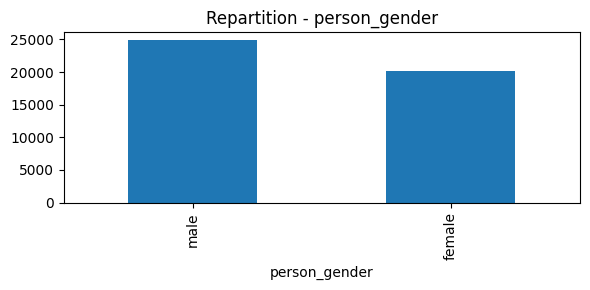

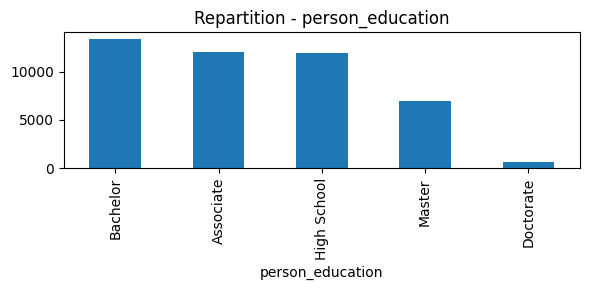

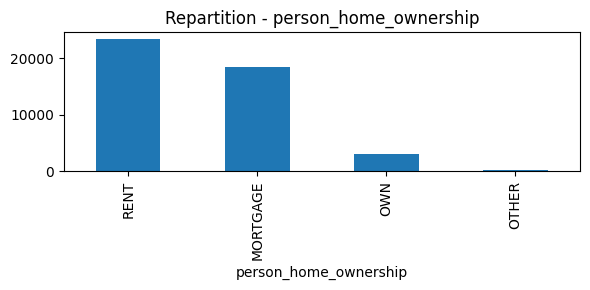

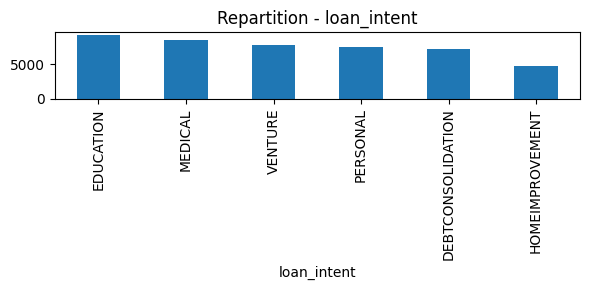

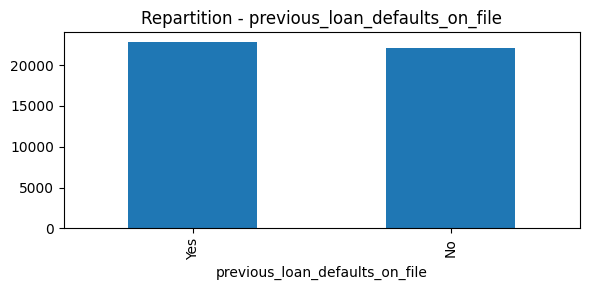

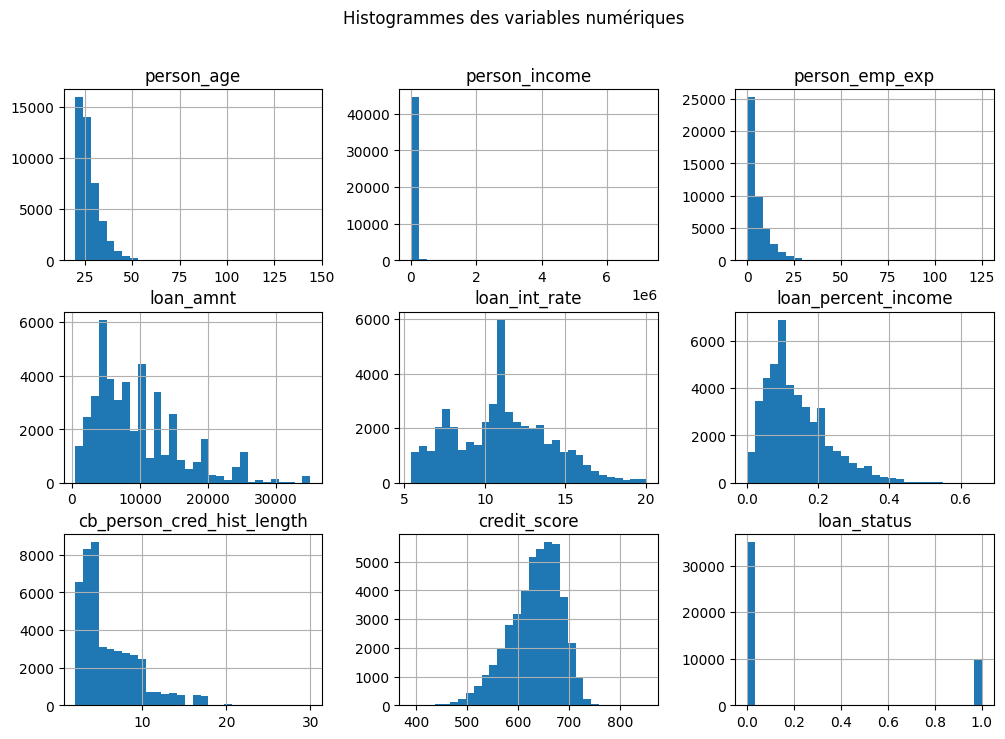

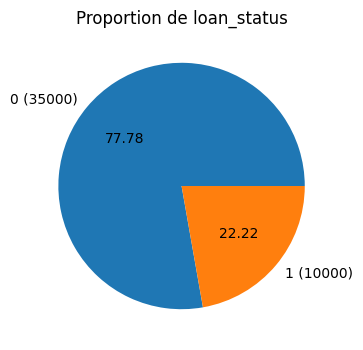

In [4]:
# EDA simple: distributions des catégorielles et des numériques
for c in cat_cols:
    plt.figure(figsize=(6,3))
    # value_counts() montre les modalités et leurs effectifs
    df[c].value_counts().plot(kind='bar', title=f'Repartition - {c}')
    plt.xlabel(c)
    plt.tight_layout()
    plt.show()

if num_cols:
    # histogrammes groupés pour repérer la forme des distributions
    df[num_cols].hist(bins=30, figsize=(12,8))
    plt.suptitle('Histogrammes des variables numériques')
    plt.show()

# Distribution de la target
if 'loan_status' in df.columns:
    counts = df['loan_status'].value_counts()
    plt.figure(figsize=(4,4))
    plt.pie(counts, labels=[str(i) + ' (' + str(n) + ')' for i,n in zip(counts.index, counts)], autopct='%.2f')
    plt.title('Proportion de loan_status')
    plt.show()


### Rééquilibrage de la target — pourquoi l'undersampling ?

Ici, nous choisissons d'équilibrer la target `loan_status` par undersampling des classes majoritaires (réduction du nombre d'exemples des classes abondantes) afin d'obtenir des classes approximativement équilibrées.

Points importants :
- L'undersampling évite d'ajouter des exemples synthétiques mais réduit la taille totale du jeu de données.
- Si la classe minoritaire est très petite, l'undersampling peut trop appauvrir l'entraînement.
- Alternative : l'upsampling, SMOTE, ou l'utilisation de `class_weight='balanced'` dans les modèles. On ne l'utilisera pas ici


In [5]:
# Rééquilibrage de la target `loan_status` à ~50/50 via undersampling (suppression d'exemples des classes majoritaires)

print('Distribution avant (counts):')
print(df['loan_status'].value_counts(dropna=False))

counts = df['loan_status'].value_counts()
min_n = counts.min()
parts = []
for cls, n in counts.items():
    subset = df[df['loan_status'] == cls]
    if n > min_n:
        # Sous-échantillonnage de la classe majoritaire jusqu'à min_n (sans remplacement)
        subset = subset.sample(n=min_n, replace=False, random_state=42)
    parts.append(subset)
df = pd.concat(parts, axis=0).sample(frac=1, random_state=42).reset_index(drop=True)
print('Distribution après (équilibrée):')
print(df['loan_status'].value_counts())


Distribution avant (counts):
loan_status
0    35000
1    10000
Name: count, dtype: int64
Distribution après (équilibrée):
loan_status
1    10000
0    10000
Name: count, dtype: int64


## Études des corrélations potentiels

Nous pouvons supposer que certains groupes sociaux sont plus enclins à avoir bénéficier d'accord pour un emprunt.

Par exemple, certains facteurs comme l'éducation, le montant emprunté, le montant par rapport au salaire, le score crédit de la personne peuvent directement avoir une influence sur l'emprunt.

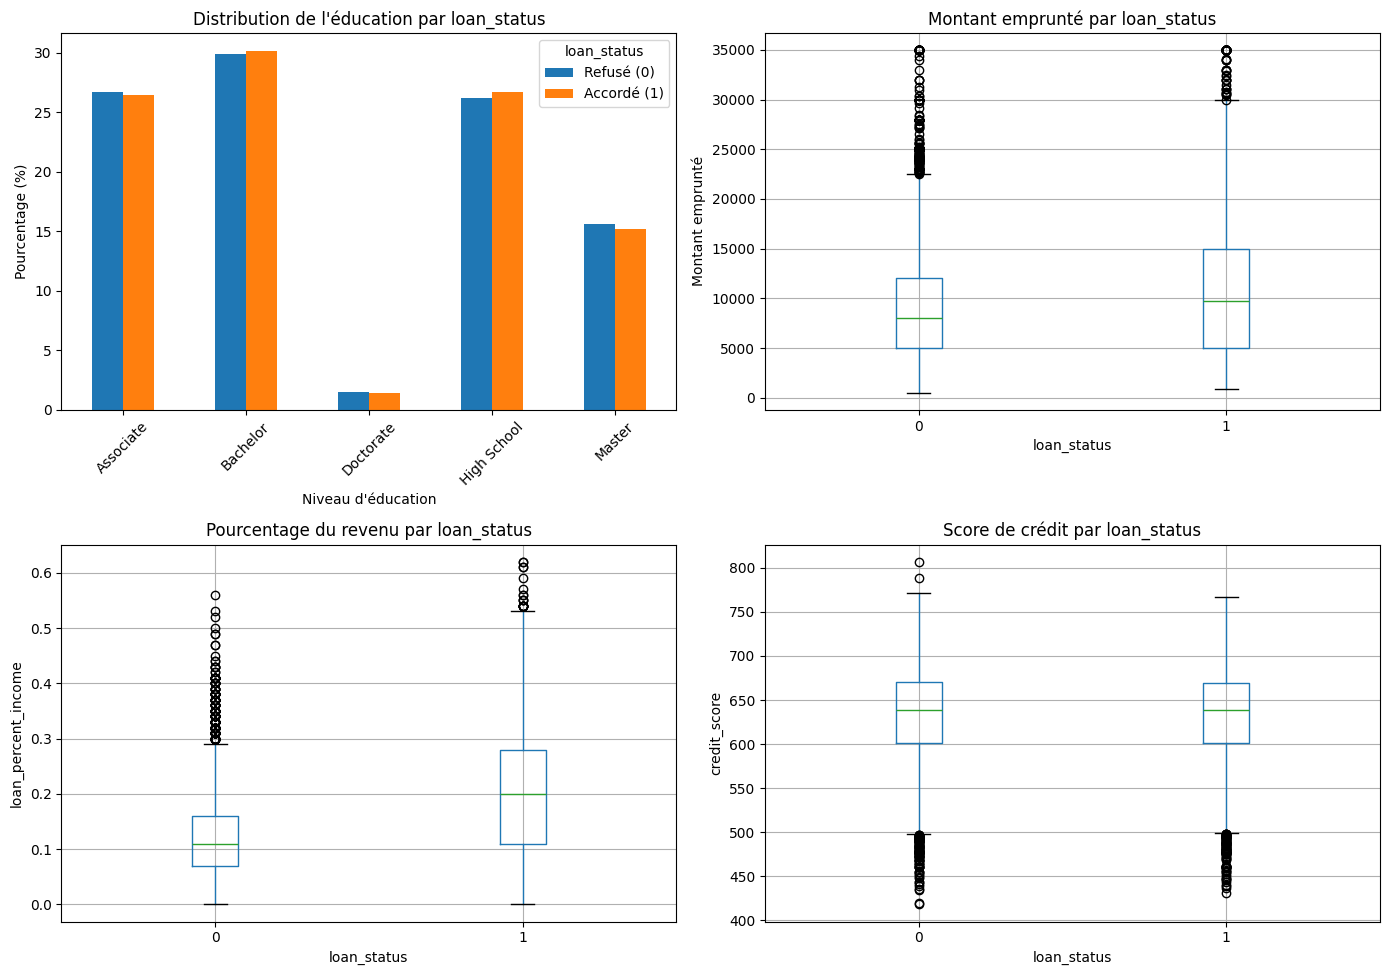

In [6]:
# Analyse de la corrélation entre loan_status et différentes variables
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Éducation vs loan_status
ax1 = axes[0, 0]
education_status = pd.crosstab(df['loan_status'], df['person_education'], normalize='index') * 100
education_status.T.plot(kind='bar', ax=ax1)
ax1.set_title('Distribution de l\'éducation par loan_status')
ax1.set_xlabel('Niveau d\'éducation')
ax1.set_ylabel('Pourcentage (%)')
ax1.legend(title='loan_status', labels=['Refusé (0)', 'Accordé (1)'])
ax1.tick_params(axis='x', rotation=45)

# 2. Montant emprunté vs loan_status
ax2 = axes[0, 1]
df.boxplot(column='loan_amnt', by='loan_status', ax=ax2)
ax2.set_title('Montant emprunté par loan_status')
ax2.set_xlabel('loan_status')
ax2.set_ylabel('Montant emprunté')
ax2.get_figure().suptitle('')

# 3. Pourcentage du revenu vs loan_status
ax3 = axes[1, 0]
df.boxplot(column='loan_percent_income', by='loan_status', ax=ax3)
ax3.set_title('Pourcentage du revenu par loan_status')
ax3.set_xlabel('loan_status')
ax3.set_ylabel('loan_percent_income')
ax3.get_figure().suptitle('')

# 4. Score de crédit vs loan_status
ax4 = axes[1, 1]
df.boxplot(column='credit_score', by='loan_status', ax=ax4)
ax4.set_title('Score de crédit par loan_status')
ax4.set_xlabel('loan_status')
ax4.set_ylabel('credit_score')
ax4.get_figure().suptitle('')

plt.tight_layout()
plt.show()

Pas vraiment de corrélation...

## Méthodes d'analyse de corrélation

Pour comprendre les relations entre les variables et la target `loan_status`, nous utilisons **trois approches complémentaires** permettant d'analyser respectivement les variables numériques et catégorielles.

---

### 1. Corrélation de Pearson (Variables numériques)

#### Définition

Le coefficient de corrélation de Pearson mesure l'intensité et la direction de la relation **linéaire** entre deux variables quantitatives.

#### Formule mathématique

$$r_{X,Y} = \frac{\sum_{i=1}^{n}(x_i - \bar{x})(y_i - \bar{y})}{\sqrt{\sum_{i=1}^{n}(x_i - \bar{x})^2} \cdot \sqrt{\sum_{i=1}^{n}(y_i - \bar{y})^2}}$$

**Où :**
- $r_{X,Y}$ : coefficient de corrélation de Pearson entre les variables X et Y
- $n$ : nombre d'observations
- $x_i$ : valeur de la variable X pour l'observation i
- $y_i$ : valeur de la variable Y pour l'observation i
- $\bar{x}$ : moyenne arithmétique de la variable X, calculée comme $\bar{x} = \frac{1}{n}\sum_{i=1}^{n}x_i$
- $\bar{y}$ : moyenne arithmétique de la variable Y, calculée comme $\bar{y} = \frac{1}{n}\sum_{i=1}^{n}y_i$

#### Interprétation des valeurs

| Valeur de r | Interprétation |
|-------------|----------------|
| r = 1 | Corrélation positive parfaite (relation linéaire croissante) |
| 0.7 ≤ r < 1 | Corrélation positive forte |
| 0.3 ≤ r < 0.7 | Corrélation positive modérée |
| 0 < r < 0.3 | Corrélation positive faible |
| r = 0 | Absence de corrélation linéaire |
| -0.3 < r < 0 | Corrélation négative faible |
| -0.7 < r ≤ -0.3 | Corrélation négative modérée |
| -1 < r ≤ -0.7 | Corrélation négative forte |
| r = -1 | Corrélation négative parfaite (relation linéaire décroissante) |

#### Hypothèses et limites

**Hypothèses :**
- Les deux variables doivent être quantitatives (continues ou discrètes)
- La relation entre les variables doit être linéaire
- Les données ne doivent pas présenter d'outliers extrêmes

**Limites importantes :**
- Ne détecte que les relations **linéaires** (relations non-linéaires ignorées)
- Sensible aux valeurs aberrantes qui peuvent fausser le coefficient
- Un coefficient de corrélation ne permet **pas** de conclure sur la causalité (corrélation ≠ causalité)
- Une corrélation nulle n'implique pas l'absence de relation (peut exister une relation non-linéaire)

#### Application dans notre étude

- **Heatmap** : visualisation globale des corrélations entre toutes les variables numériques du dataset
- **Corrélation avec loan_status** : identification des variables numériques les plus prédictives de l'approbation du prêt

---

### 2. Test du Chi² (χ²) - Variables catégorielles

#### Définition

Le test du Chi² d'indépendance est un test statistique permettant de déterminer si deux variables catégorielles sont indépendantes ou s'il existe une association significative entre elles.

#### Hypothèses statistiques

- **H₀** (hypothèse nulle) : les deux variables sont **indépendantes** (aucune association)
- **H₁** (hypothèse alternative) : les deux variables sont **dépendantes** (association significative)

#### Statistique de test

$$\chi^2 = \sum_{i=1}^{r} \sum_{j=1}^{c} \frac{(O_{ij} - E_{ij})^2}{E_{ij}}$$

**Où :**
- $\chi^2$ : statistique du Chi² calculée
- $r$ : nombre de lignes du tableau de contingence (nombre de modalités de la première variable)
- $c$ : nombre de colonnes du tableau de contingence (nombre de modalités de la seconde variable)
- $O_{ij}$ : fréquence **observée** dans la cellule (i, j), c'est-à-dire le nombre réel d'observations
- $E_{ij}$ : fréquence **attendue** dans la cellule (i, j) sous l'hypothèse d'indépendance

#### Calcul des fréquences attendues

Sous l'hypothèse d'indépendance (H₀), la fréquence attendue pour chaque cellule est calculée comme :

$$E_{ij} = \frac{(\text{total ligne } i) \times (\text{total colonne } j)}{\text{total général}}$$

Plus formellement :

$$E_{ij} = \frac{n_{i\cdot} \times n_{\cdot j}}{n}$$

**Où :**
- $n_{i\cdot}$ : somme marginale de la ligne i (total de la ligne)
- $n_{\cdot j}$ : somme marginale de la colonne j (total de la colonne)
- $n$ : effectif total (somme de toutes les observations)

#### Interprétation de la p-value

La p-value représente la probabilité d'observer une statistique χ² aussi extrême (ou plus) que celle calculée, si H₀ est vraie.

| p-value | Décision | Interprétation |
|---------|----------|----------------|
| p < 0.05 | Rejet de H₀ | Les variables sont significativement dépendantes (association statistiquement significative au seuil α = 5%) |
| p ≥ 0.05 | Non-rejet de H₀ | Pas de preuve suffisante d'une dépendance (les variables peuvent être considérées comme indépendantes) |

Note : Le seuil α = 0.05 est conventionnel mais peut être ajusté selon le contexte (0.01 ou 0.10).

#### Conditions d'application

- Les observations doivent être indépendantes
- Les effectifs attendus doivent être suffisamment grands : $E_{ij} \geq 5$ pour au moins 80% des cellules
- Si cette condition n'est pas respectée, utiliser le test exact de Fisher

#### Limites

- Le test du Chi² indique uniquement la **significativité** de l'association (existence d'un lien)
- Il ne mesure **pas l'intensité** de cette association
- Sensible à la taille de l'échantillon : avec un grand n, des associations faibles peuvent devenir significatives

---

### 3. Cramér's V - Intensité de l'association

#### Définition

Le V de Cramér est une mesure normalisée de l'intensité de l'association entre deux variables catégorielles. Il complète le test du Chi² en quantifiant la **force** de l'association détectée.

#### Formule de calcul

$$V = \sqrt{\frac{\chi^2}{n \times \min(r-1, c-1)}}$$

**Où :**
- $V$ : coefficient V de Cramér (compris entre 0 et 1)
- $\chi^2$ : statistique du Chi² calculée précédemment
- $n$ : nombre total d'observations
- $r$ : nombre de lignes du tableau de contingence
- $c$ : nombre de colonnes du tableau de contingence
- $\min(r-1, c-1)$ : le minimum entre (r-1) et (c-1), utilisé pour la normalisation

#### Interprétation des valeurs

| Valeur de V | Intensité de l'association |
|-------------|---------------------------|
| V = 0 | Aucune association (indépendance parfaite) |
| 0 < V < 0.1 | Association négligeable |
| 0.1 ≤ V < 0.3 | Association faible |
| 0.3 ≤ V < 0.5 | Association modérée |
| V ≥ 0.5 | Association forte |
| V = 1 | Association parfaite (dépendance complète) |

#### Avantages

- **Normalisation** : valeur comprise entre 0 et 1, permettant la comparaison entre différentes paires de variables
- **Interprétation intuitive** : plus V est élevé, plus l'association est forte
- **Complément du Chi²** : combine significativité (Chi²) et intensité (V de Cramér)

#### Différence avec le Chi²

| Critère | Chi² (p-value) | V de Cramér |
|---------|----------------|-------------|
| Nature | Test d'hypothèse | Mesure d'association |
| Réponse | Existe-t-il une association ? (oui/non) | Quelle est l'intensité de l'association ? |
| Interprétation | Significativité statistique | Force de la relation |
| Sensibilité à n | Très sensible (augmente avec n) | Peu sensible (normalisé) |

---

### Synthèse méthodologique

| Méthode | Type de variables | Ce qu'elle mesure | Valeur critique | Interprétation |
|---------|-------------------|-------------------|-----------------|----------------|
| **Pearson (r)** | Numérique ↔ Numérique | Force et direction de la relation linéaire | \|r\| > 0.5 | Forte corrélation linéaire |
| **Chi² (p-value)** | Catégorielle ↔ Catégorielle | Significativité statistique de la dépendance | p < 0.05 | Association statistiquement significative |
| **Cramér's V** | Catégorielle ↔ Catégorielle | Intensité de l'association | V > 0.3 | Association modérée à forte |

---

### Application au contexte bancaire

Dans notre étude de prédiction d'approbation de prêt, ces méthodes permettent d'identifier :

**Variables numériques (Pearson) :**
- Corrélation entre `credit_score` et `loan_status`
- Relation entre `loan_amnt` et `person_income`
- Impact de `loan_percent_income` sur l'approbation

**Variables catégorielles (Chi² et Cramér's V) :**
- Association entre `person_education` et `loan_status`
- Lien entre `loan_intent` et l'approbation du prêt
- Influence du `person_home_ownership` sur la décision

Cette analyse multidimensionnelle permet de sélectionner les features les plus pertinentes pour la modélisation prédictive.

---

### Références bibliographiques

- Pearson, K. (1895). "Notes on regression and inheritance in the case of two parents". *Proceedings of the Royal Society of London*, 58, 240-242.
- Pearson, K. (1900). "On the criterion that a given system of deviations from the probable in the case of a correlated system of variables is such that it can be reasonably supposed to have arisen from random sampling". *Philosophical Magazine*, 50(302), 157-175.
- Cramér, H. (1946). *Mathematical Methods of Statistics*. Princeton University Press.
- Cohen, J. (1988). *Statistical Power Analysis for the Behavioral Sciences* (2nd ed.). Routledge.

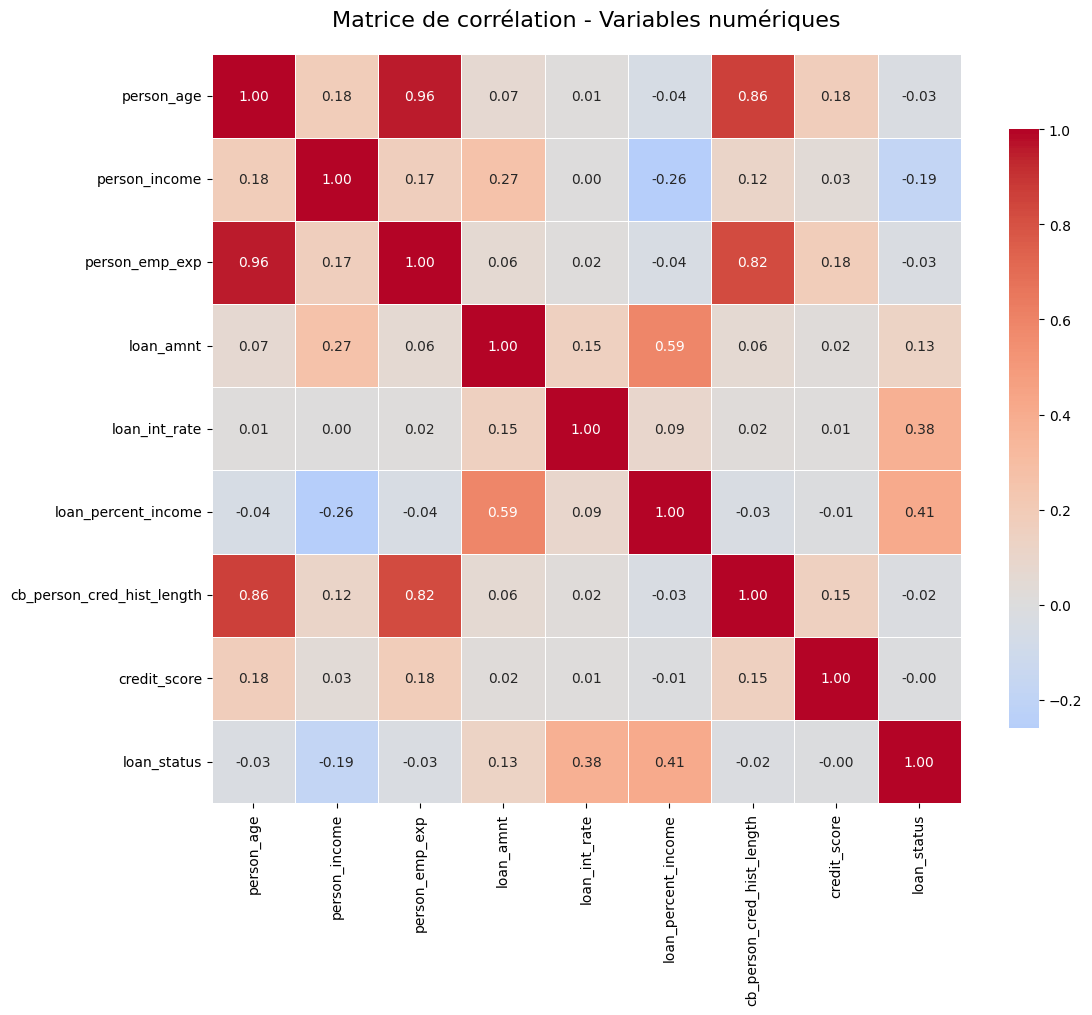


 Paires de variables fortement corrélées (|r| > 0.5):
  • person_age ↔ person_emp_exp: 0.955
  • person_age ↔ cb_person_cred_hist_length: 0.860
  • person_emp_exp ↔ cb_person_cred_hist_length: 0.823
  • loan_amnt ↔ loan_percent_income: 0.588


In [7]:
## Analyse approfondie des corrélations

### 1. Heatmap de corrélation (variables numériques)

import seaborn as sns

# Calculer la matrice de corrélation pour toutes les variables numériques
correlation_matrix = df[num_cols].corr()

# Créer la heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(
    correlation_matrix, 
    annot=True,           # Afficher les valeurs
    fmt='.2f',            # Format des nombres (2 décimales)
    cmap='coolwarm',      # Palette de couleurs (bleu=négatif, rouge=positif)
    center=0,             # Centrer sur 0
    square=True,          # Cellules carrées
    linewidths=0.5,       # Lignes entre cellules
    cbar_kws={"shrink": 0.8}
)
plt.title('Matrice de corrélation - Variables numériques', fontsize=16, pad=20)
plt.tight_layout()
plt.show()

# Identifier les corrélations fortes (hors diagonale)
print("\n Paires de variables fortement corrélées (|r| > 0.5):")
print("="*60)

# Extraire les corrélations fortes
strong_corr = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        corr_value = correlation_matrix.iloc[i, j]
        if abs(corr_value) > 0.5:
            var1 = correlation_matrix.columns[i]
            var2 = correlation_matrix.columns[j]
            strong_corr.append((var1, var2, corr_value))

# Trier par valeur absolue décroissante
strong_corr.sort(key=lambda x: abs(x[2]), reverse=True)

if strong_corr:
    for var1, var2, corr in strong_corr:
        print(f"  • {var1} ↔ {var2}: {corr:.3f}")
else:
    print("  Aucune corrélation forte détectée (toutes < 0.5)")

array([[<Axes: xlabel='person_age', ylabel='person_age'>,
        <Axes: xlabel='person_emp_exp', ylabel='person_age'>],
       [<Axes: xlabel='person_age', ylabel='person_emp_exp'>,
        <Axes: xlabel='person_emp_exp', ylabel='person_emp_exp'>]],
      dtype=object)

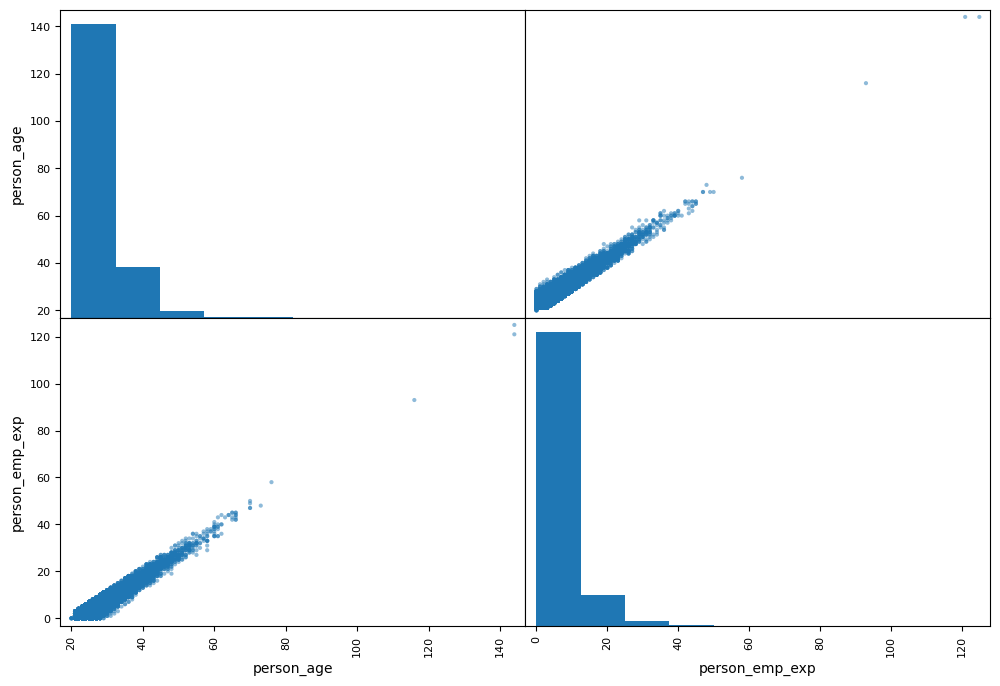

In [8]:
from pandas.plotting import scatter_matrix
scatter_matrix(df[["person_age", "person_emp_exp"]], figsize=(12,8))

C'est normal, il est logique que, plus une personne vieillisse, plus elle travaille. Il en est de même pour les deux autres corrélations croissante.


 Corrélation des variables numériques avec loan_status:
loan_status                   1.000000
loan_percent_income           0.408312
loan_int_rate                 0.378065
loan_amnt                     0.127048
credit_score                 -0.004529
cb_person_cred_hist_length   -0.020064
person_emp_exp               -0.026777
person_age                   -0.027542
person_income                -0.185783


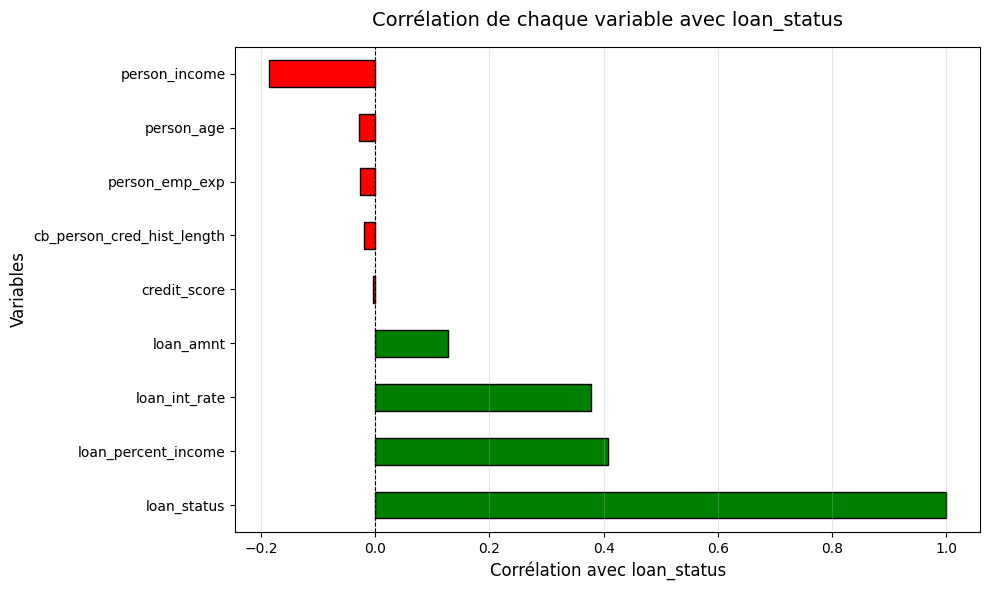


 Interprétation:

 Top 3 variables FAVORISANT l'approbation (corrélation positive):
  • loan_percent_income: 0.408
  • loan_int_rate: 0.378

 Top 3 variables DÉFAVORISANT l'approbation (corrélation négative):
  • person_emp_exp: -0.027
  • person_age: -0.028
  • person_income: -0.186
\ Variables avec corrélation significative (|r| > 0.1): 4


In [9]:
### 2. Corrélation avec loan_status uniquement

# Calculer la corrélation de toutes les variables numériques avec loan_status
correlations_with_target = df[num_cols].corrwith(df['loan_status']).sort_values(ascending=False)

# Afficher le tableau
print("\n Corrélation des variables numériques avec loan_status:")
print(correlations_with_target.to_string())

# Visualisation en barplot
plt.figure(figsize=(10, 6))
colors = ['green' if x > 0 else 'red' for x in correlations_with_target.values]
correlations_with_target.plot(kind='barh', color=colors, edgecolor='black')
plt.xlabel('Corrélation avec loan_status', fontsize=12)
plt.ylabel('Variables', fontsize=12)
plt.title('Corrélation de chaque variable avec loan_status', fontsize=14, pad=15)
plt.axvline(x=0, color='black', linestyle='--', linewidth=0.8)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

# Interpréter les résultats
print("\n Interprétation:")
top_positive = correlations_with_target.head(3)
top_negative = correlations_with_target.tail(3)

print("\n Top 3 variables FAVORISANT l'approbation (corrélation positive):")
for var, corr in top_positive.items():
    if var != 'loan_status':
        print(f"  • {var}: {corr:.3f}")
        
print("\n Top 3 variables DÉFAVORISANT l'approbation (corrélation négative):")
for var, corr in top_negative.items():
    if var != 'loan_status':
        print(f"  • {var}: {corr:.3f}")

# Seuil de significativité
significant_vars = correlations_with_target[abs(correlations_with_target) > 0.1]
print(f"\ Variables avec corrélation significative (|r| > 0.1): {len(significant_vars)-1}")

ANALYSE APPROFONDIE DES CORRÉLATIONS AVEC LOAN_STATUS

1. VARIABLES À CORRÉLATION POSITIVE (plus la valeur augmente, plus l'approbation augmente)

────────────────────────────────────────────────────────────────────────────────
Variable : loan_percent_income
Corrélation avec loan_status : 0.408

Statistiques descriptives par loan_status :
               count      mean       std  min   25%   50%   75%   max
loan_status                                                          
0            10000.0  0.121726  0.070497  0.0  0.07  0.11  0.16  0.56
1            10000.0  0.202521  0.106514  0.0  0.11  0.20  0.28  0.62

Test de Student (différence de moyennes) :
  • Statistique t : -63.254
  • p-value : 0.0000e+00
  • Conclusion : Différence SIGNIFICATIVE


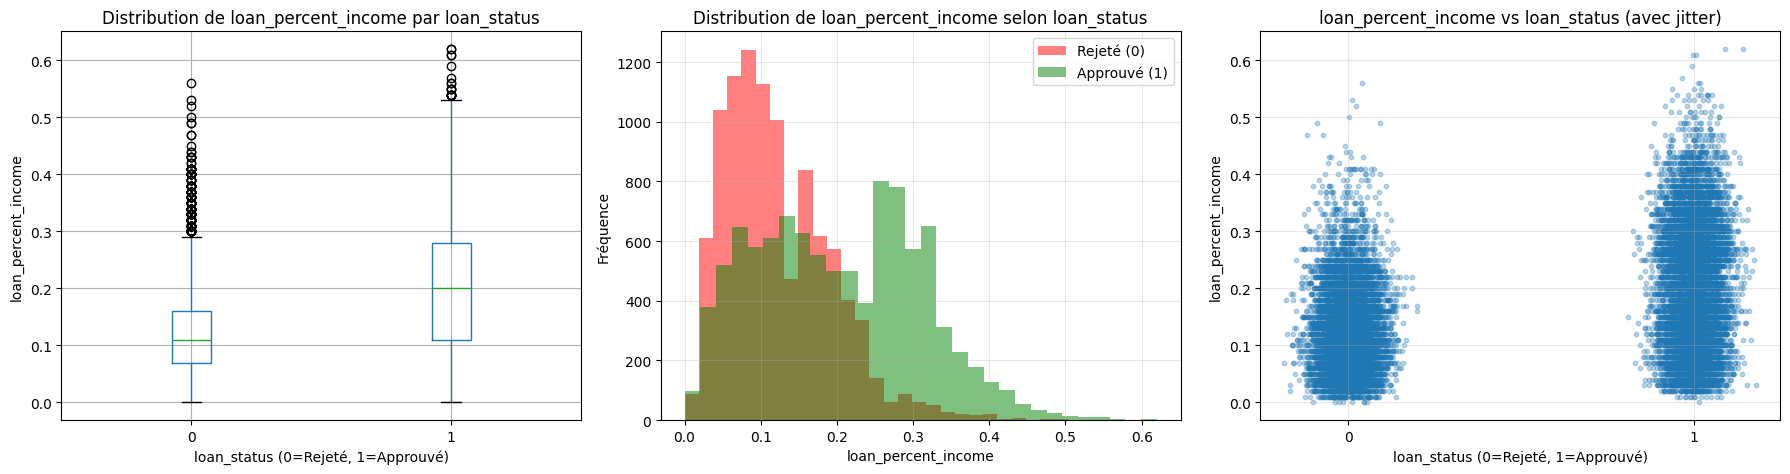


────────────────────────────────────────────────────────────────────────────────
Variable : loan_int_rate
Corrélation avec loan_status : 0.378

Statistiques descriptives par loan_status :
               count       mean       std   min      25%     50%      75%  \
loan_status                                                                 
0            10000.0  10.489786  2.717286  5.42   7.9075  10.885  12.2825   
1            10000.0  12.856794  3.068512  5.42  10.9900  12.980  15.2300   

              max  
loan_status        
0            20.0  
1            20.0  

Test de Student (différence de moyennes) :
  • Statistique t : -57.750
  • p-value : 0.0000e+00
  • Conclusion : Différence SIGNIFICATIVE


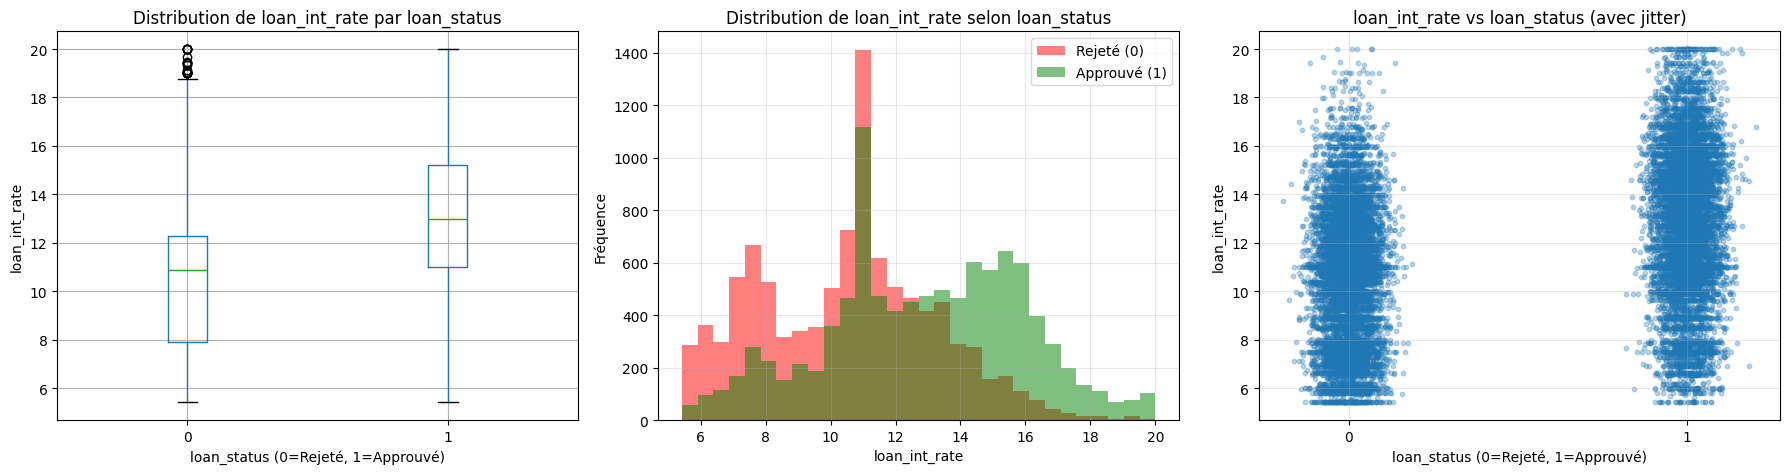

2. VARIABLES À CORRÉLATION NÉGATIVE (plus la valeur augmente, moins l'approbation augmente)
Variable : person_income
Corrélation avec loan_status : -0.186

Statistiques descriptives par loan_status :
               count        mean           std     min       25%      50%  \
loan_status                                                                 
0            10000.0  85299.2755  83535.317384  9732.0  51456.75  72915.0   
1            10000.0  59886.0969  45338.315604  8000.0  36841.75  50629.0   

                   75%        max  
loan_status                        
0            101957.25  5545545.0  
1             71888.25   845636.0  

Test de Student (différence de moyennes) :
  • Statistique t : 26.738
  • p-value : 8.9417e-155
  • Conclusion : Différence SIGNIFICATIVE


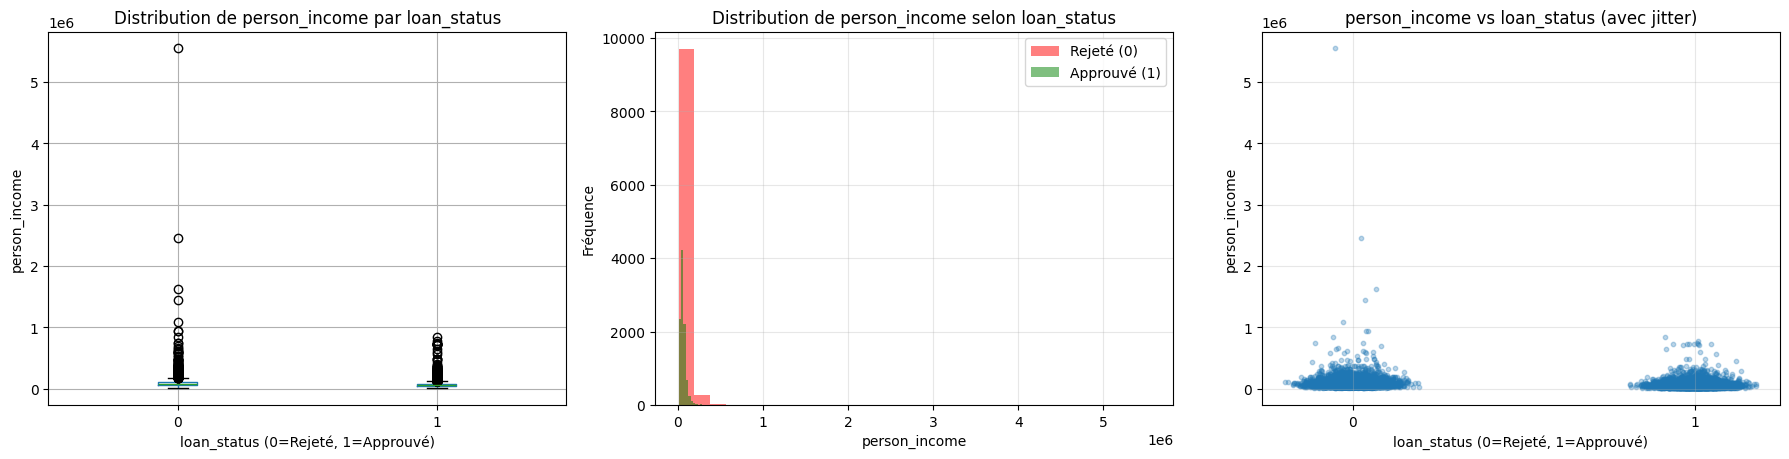

Variable : credit_score
Corrélation avec loan_status : -0.005

Statistiques descriptives par loan_status :
               count      mean        std    min    25%    50%    75%    max
loan_status                                                                 
0            10000.0  632.3449  50.759212  418.0  601.0  639.0  670.0  807.0
1            10000.0  631.8872  50.293485  431.0  601.0  639.0  669.0  767.0

Test de Student (différence de moyennes) :
  • Statistique t : 0.641
  • p-value : 5.2183e-01
  • Conclusion : Pas de différence significative


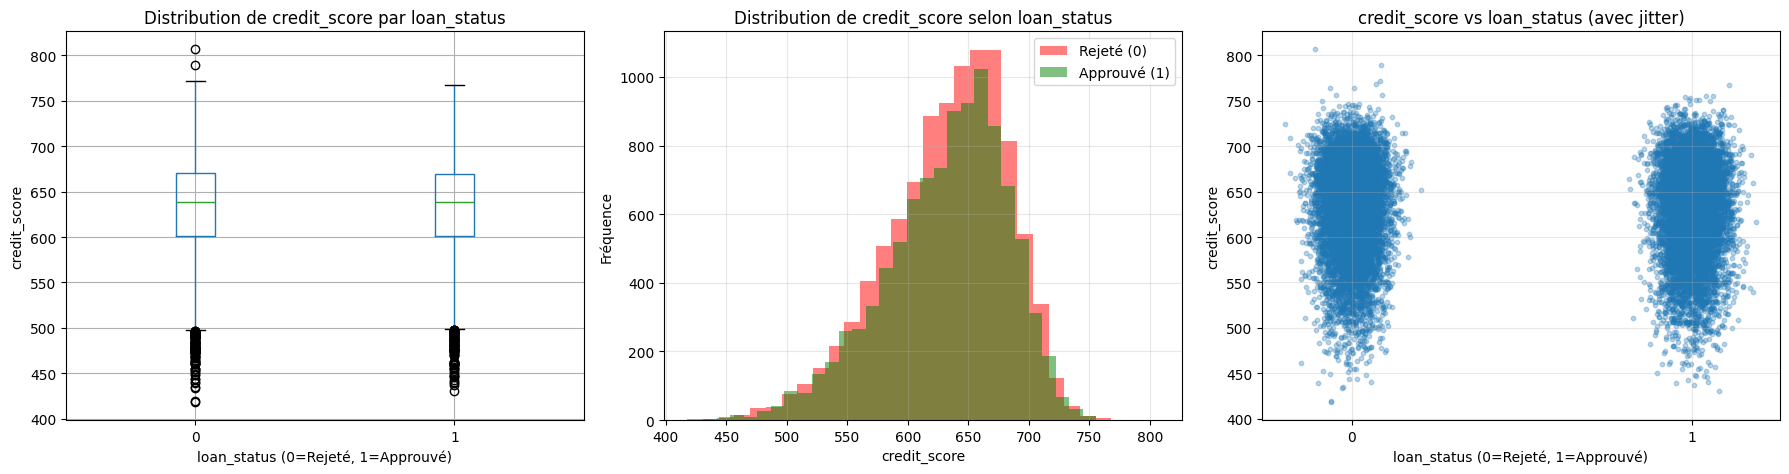

Variable : person_age
Corrélation avec loan_status : -0.028

Statistiques descriptives par loan_status :
               count     mean       std   min   25%   50%   75%    max
loan_status                                                           
0            10000.0  27.8568  6.234547  20.0  24.0  26.0  30.0  144.0
1            10000.0  27.5213  5.939063  20.0  23.0  26.0  30.0   70.0

Test de Student (différence de moyennes) :
  • Statistique t : 3.896
  • p-value : 9.7963e-05
  • Conclusion : Différence SIGNIFICATIVE


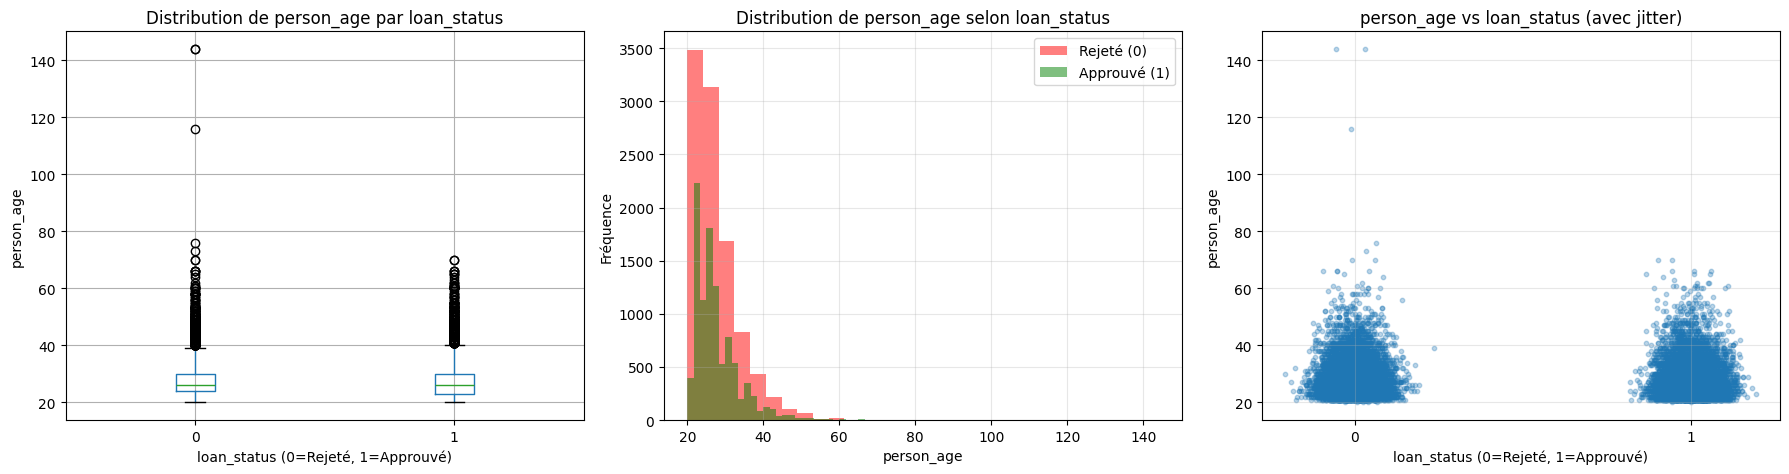

Variable : person_emp_exp
Corrélation avec loan_status : -0.027

Statistiques descriptives par loan_status :
               count    mean       std  min  25%  50%  75%    max
loan_status                                                      
0            10000.0  5.5052  6.296470  0.0  1.0  4.0  8.0  125.0
1            10000.0  5.1780  5.913207  0.0  1.0  3.0  8.0   47.0

Test de Student (différence de moyennes) :
  • Statistique t : 3.788
  • p-value : 1.5231e-04
  • Conclusion : Différence SIGNIFICATIVE


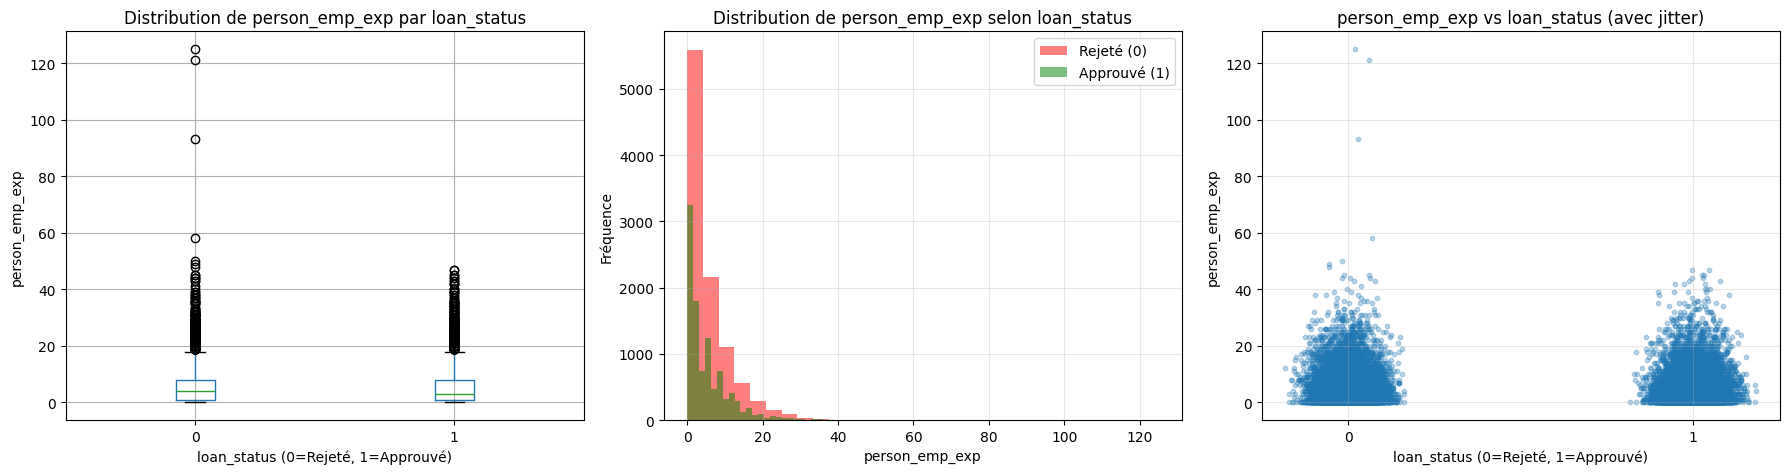



3. ANALYSE MULTIVARIÉE : INTERACTIONS ENTRE VARIABLES

Création d'un pairplot des variables significatives...


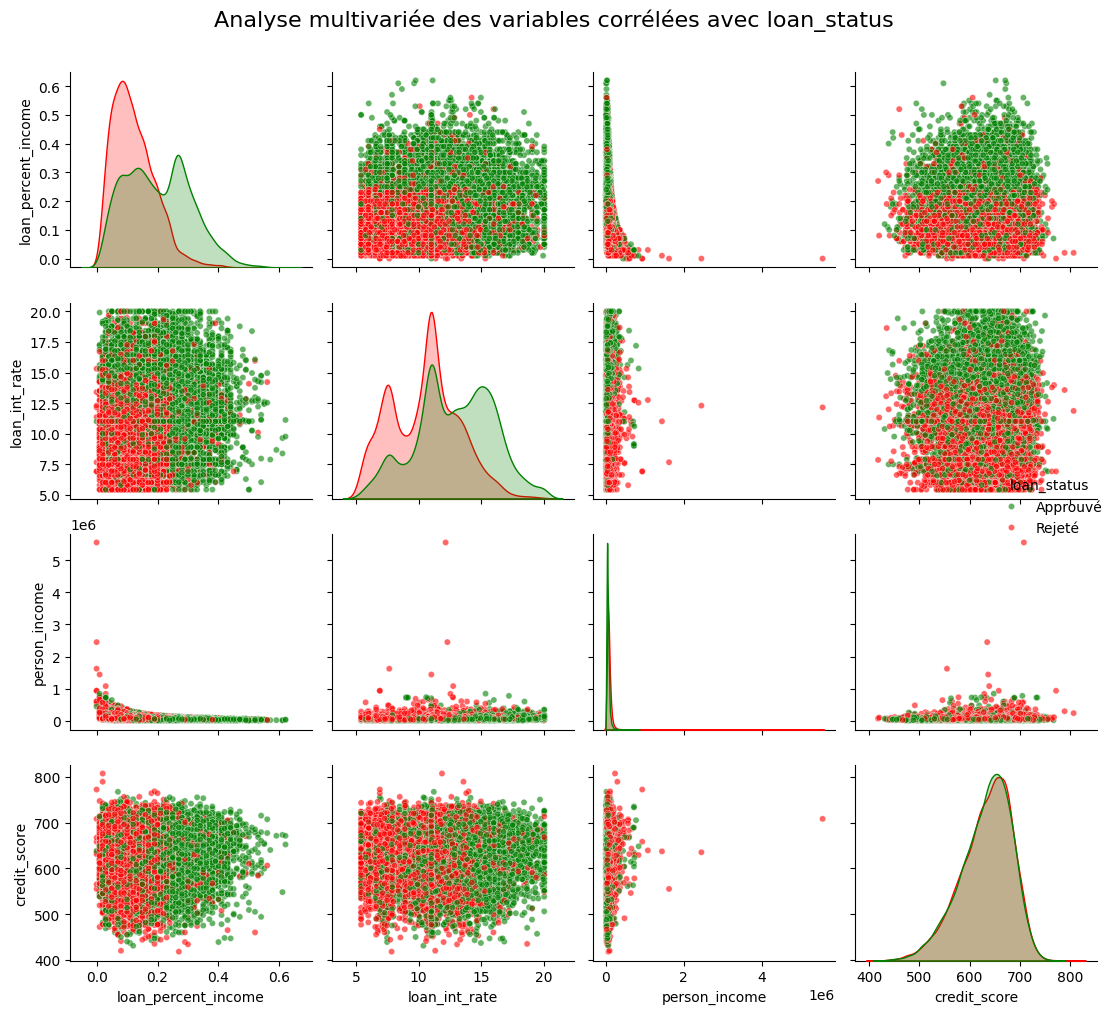


Matrice de corrélation des variables significatives :


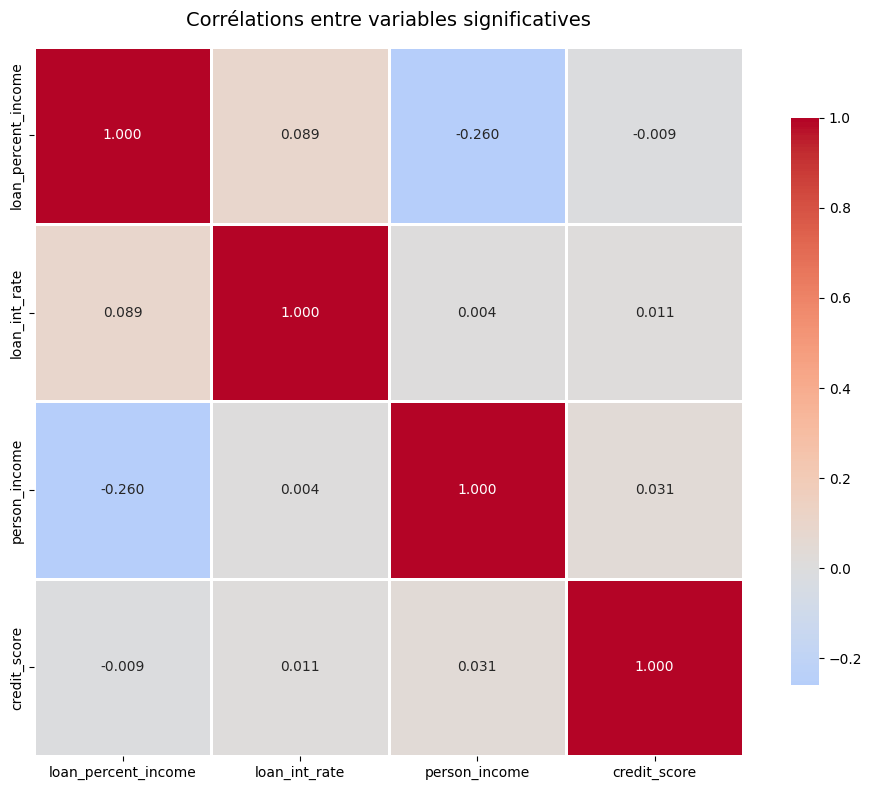

In [10]:
### Analyse détaillée des corrélations significatives

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Variables à analyser en détail
variables_to_analyze = {
    'positive': ['loan_percent_income', 'loan_int_rate'],
    'negative': ['person_income', 'credit_score', 'person_age', 'person_emp_exp']
}


print("ANALYSE APPROFONDIE DES CORRÉLATIONS AVEC LOAN_STATUS")


# PARTIE 1 : CORRÉLATIONS POSITIVES (favorisent l'approbation)

print("\n" + "="*80)
print("1. VARIABLES À CORRÉLATION POSITIVE (plus la valeur augmente, plus l'approbation augmente)")
print("="*80)

for var in variables_to_analyze['positive']:
    corr = df[num_cols].corrwith(df['loan_status'])[var]
    
    print(f"\n{'─'*80}")
    print(f"Variable : {var}")
    print(f"Corrélation avec loan_status : {corr:.3f}")
    
    # Statistiques descriptives par statut
    print("\nStatistiques descriptives par loan_status :")
    stats = df.groupby('loan_status')[var].describe()
    print(stats)
    
    # Test statistique (t-test)
    from scipy.stats import ttest_ind
    group_0 = df[df['loan_status'] == 0][var].dropna()
    group_1 = df[df['loan_status'] == 1][var].dropna()
    t_stat, p_value = ttest_ind(group_0, group_1)
    
    print(f"\nTest de Student (différence de moyennes) :")
    print(f"  • Statistique t : {t_stat:.3f}")
    print(f"  • p-value : {p_value:.4e}")
    print(f"  • Conclusion : {'Différence SIGNIFICATIVE' if p_value < 0.05 else 'Pas de différence significative'}")
    
    # Visualisation
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # Boxplot
    ax1 = axes[0]
    df.boxplot(column=var, by='loan_status', ax=ax1)
    ax1.set_title(f'Distribution de {var} par loan_status')
    ax1.set_xlabel('loan_status (0=Rejeté, 1=Approuvé)')
    ax1.set_ylabel(var)
    ax1.get_figure().suptitle('')
    
    # Histogrammes superposés
    ax2 = axes[1]
    df[df['loan_status'] == 0][var].hist(bins=30, alpha=0.5, label='Rejeté (0)', ax=ax2, color='red')
    df[df['loan_status'] == 1][var].hist(bins=30, alpha=0.5, label='Approuvé (1)', ax=ax2, color='green')
    ax2.set_xlabel(var)
    ax2.set_ylabel('Fréquence')
    ax2.set_title(f'Distribution de {var} selon loan_status')
    ax2.legend()
    ax2.grid(alpha=0.3)
    
    # Scatter plot avec jitter
    ax3 = axes[2]
    jitter = np.random.normal(0, 0.05, size=len(df))
    ax3.scatter(df['loan_status'] + jitter, df[var], alpha=0.3, s=10)
    ax3.set_xlabel('loan_status (0=Rejeté, 1=Approuvé)')
    ax3.set_ylabel(var)
    ax3.set_title(f'{var} vs loan_status (avec jitter)')
    ax3.set_xticks([0, 1])
    ax3.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    


# PARTIE 2 : CORRÉLATIONS NÉGATIVES (défavorisent l'approbation)

print("2. VARIABLES À CORRÉLATION NÉGATIVE (plus la valeur augmente, moins l'approbation augmente)")

for var in variables_to_analyze['negative']:
    corr = df[num_cols].corrwith(df['loan_status'])[var]
    
    print(f"Variable : {var}")
    print(f"Corrélation avec loan_status : {corr:.3f}")
    
    # Statistiques descriptives par statut
    print("\nStatistiques descriptives par loan_status :")
    stats = df.groupby('loan_status')[var].describe()
    print(stats)
    
    # Test statistique (t-test)
    group_0 = df[df['loan_status'] == 0][var].dropna()
    group_1 = df[df['loan_status'] == 1][var].dropna()
    t_stat, p_value = ttest_ind(group_0, group_1)
    
    print(f"\nTest de Student (différence de moyennes) :")
    print(f"  • Statistique t : {t_stat:.3f}")
    print(f"  • p-value : {p_value:.4e}")
    print(f"  • Conclusion : {'Différence SIGNIFICATIVE' if p_value < 0.05 else 'Pas de différence significative'}")
    
    # Visualisation
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # Boxplot
    ax1 = axes[0]
    df.boxplot(column=var, by='loan_status', ax=ax1)
    ax1.set_title(f'Distribution de {var} par loan_status')
    ax1.set_xlabel('loan_status (0=Rejeté, 1=Approuvé)')
    ax1.set_ylabel(var)
    ax1.get_figure().suptitle('')
    
    # Histogrammes superposés
    ax2 = axes[1]
    df[df['loan_status'] == 0][var].hist(bins=30, alpha=0.5, label='Rejeté (0)', ax=ax2, color='red')
    df[df['loan_status'] == 1][var].hist(bins=30, alpha=0.5, label='Approuvé (1)', ax=ax2, color='green')
    ax2.set_xlabel(var)
    ax2.set_ylabel('Fréquence')
    ax2.set_title(f'Distribution de {var} selon loan_status')
    ax2.legend()
    ax2.grid(alpha=0.3)
    
    # Scatter plot avec jitter
    ax3 = axes[2]
    jitter = np.random.normal(0, 0.05, size=len(df))
    ax3.scatter(df['loan_status'] + jitter, df[var], alpha=0.3, s=10)
    ax3.set_xlabel('loan_status (0=Rejeté, 1=Approuvé)')
    ax3.set_ylabel(var)
    ax3.set_title(f'{var} vs loan_status (avec jitter)')
    ax3.set_xticks([0, 1])
    ax3.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    

# PARTIE 3 : ANALYSE MULTIVARIÉE

print("\n\n" + "="*80)
print("3. ANALYSE MULTIVARIÉE : INTERACTIONS ENTRE VARIABLES")

# Pairplot des variables les plus corrélées
significant_vars = ['loan_percent_income', 'loan_int_rate', 'person_income', 'credit_score', 'loan_status']
pairplot_data = df[significant_vars].copy()
pairplot_data['loan_status'] = pairplot_data['loan_status'].map({0: 'Rejeté', 1: 'Approuvé'})

print("\nCréation d'un pairplot des variables significatives...")
g = sns.pairplot(pairplot_data, hue='loan_status', palette={'Rejeté': 'red', 'Approuvé': 'green'}, 
                 diag_kind='kde', plot_kws={'alpha': 0.6, 's': 20})
g.fig.suptitle('Analyse multivariée des variables corrélées avec loan_status', y=1.01, fontsize=16)
plt.tight_layout()
plt.show()

# Matrice de corrélation des variables significatives
print("\nMatrice de corrélation des variables significatives :")
corr_matrix = df[significant_vars[:-1]].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.3f', cmap='coolwarm', center=0, 
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Corrélations entre variables significatives', fontsize=14, pad=15)
plt.tight_layout()
plt.show()




🔬 Test du Chi² - Dépendance entre variables catégorielles et loan_status

                      Variable        Chi²       p-value  Cramér V Significatif (α=0.05)
         person_home_ownership 1937.780541  0.000000e+00  0.311270                   OUI
previous_loan_defaults_on_file 9661.821646  0.000000e+00  0.695048                   OUI
                   loan_intent  568.360218 1.384176e-120  0.168576                   OUI
                 person_gender    0.547218  4.594565e-01  0.005231                   NON
              person_education    1.457319  8.341741e-01  0.008536                   NON


 Interprétation des résultats:
• p-value < 0.05 → La variable est DÉPENDANTE de loan_status (corrélation significative)
• p-value ≥ 0.05 → La variable est INDÉPENDANTE de loan_status (pas de lien)
• Cramér's V : intensité de l'association (0 = aucune, 1 = association parfaite)
  - V < 0.1 : négligeable
  - 0.1 ≤ V < 0.3 : faible
  - 0.3 ≤ V < 0.5 : modérée
  - V ≥ 0.5 : forte

 Variable

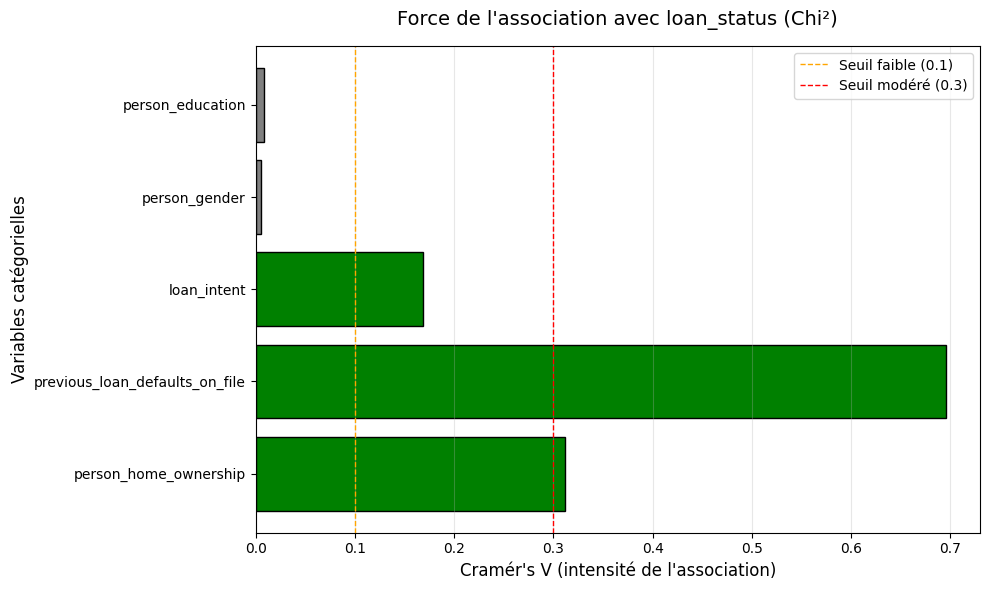

In [11]:
### 3. Test du Chi² pour variables catégorielles

from scipy.stats import chi2_contingency
import warnings
warnings.filterwarnings('ignore')

print("\n🔬 Test du Chi² - Dépendance entre variables catégorielles et loan_status")
print("="*80)

# Stocker les résultats
chi2_results = []

# Tester chaque variable catégorielle (sauf loan_status elle-même)
for cat_var in cat_cols:
    if cat_var != 'loan_status':
        # Créer le tableau de contingence
        contingency_table = pd.crosstab(df[cat_var], df['loan_status'])
        
        # Effectuer le test du Chi²
        chi2, p_value, dof, expected = chi2_contingency(contingency_table)
        
        # Calculer le Cramér's V (mesure d'association normalisée)
        n = contingency_table.sum().sum()
        min_dim = min(contingency_table.shape) - 1
        cramers_v = np.sqrt(chi2 / (n * min_dim)) if min_dim > 0 else 0
        
        # Déterminer la significativité
        is_significant = " OUI" if p_value < 0.05 else " NON"
        
        chi2_results.append({
            'Variable': cat_var,
            'Chi²': chi2,
            'p-value': p_value,
            'Cramér V': cramers_v,
            'Significatif (α=0.05)': is_significant
        })

# Créer un DataFrame des résultats
chi2_df = pd.DataFrame(chi2_results).sort_values('p-value')

# Afficher le tableau
print("\n" + chi2_df.to_string(index=False))

# Interprétation détaillée
print("\n\n Interprétation des résultats:")
print("="*80)
print("• p-value < 0.05 → La variable est DÉPENDANTE de loan_status (corrélation significative)")
print("• p-value ≥ 0.05 → La variable est INDÉPENDANTE de loan_status (pas de lien)")
print("• Cramér's V : intensité de l'association (0 = aucune, 1 = association parfaite)")
print("  - V < 0.1 : négligeable")
print("  - 0.1 ≤ V < 0.3 : faible")
print("  - 0.3 ≤ V < 0.5 : modérée")
print("  - V ≥ 0.5 : forte")

# Variables significatives
significant_cats = chi2_df[chi2_df['p-value'] < 0.05]
if len(significant_cats) > 0:
    print(f"\n Variables catégorielles significatives: {len(significant_cats)}/{len(cat_cols)}")
    for _, row in significant_cats.iterrows():
        strength = "forte" if row['Cramér V'] >= 0.5 else "modérée" if row['Cramér V'] >= 0.3 else "faible"
        print(f"  • {row['Variable']}: p={row['p-value']:.4f}, V={row['Cramér V']:.3f} (association {strength})")
else:
    print("\n Aucune variable catégorielle n'est significativement associée à loan_status")

# Visualisation du Cramér's V
plt.figure(figsize=(10, 6))
plt.barh(chi2_df['Variable'], chi2_df['Cramér V'], 
         color=['green' if p < 0.05 else 'gray' for p in chi2_df['p-value']],
         edgecolor='black')
plt.xlabel("Cramér's V (intensité de l'association)", fontsize=12)
plt.ylabel('Variables catégorielles', fontsize=12)
plt.title("Force de l'association avec loan_status (Chi²)", fontsize=14, pad=15)
plt.axvline(x=0.1, color='orange', linestyle='--', linewidth=1, label='Seuil faible (0.1)')
plt.axvline(x=0.3, color='red', linestyle='--', linewidth=1, label='Seuil modéré (0.3)')
plt.legend()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

ANALYSE APPROFONDIE DES VARIABLES CATÉGORIELLES AVEC LOAN_STATUS

────────────────────────────────────────────────────────────────────────────────
Variable : person_home_ownership
────────────────────────────────────────────────────────────────────────────────

 Tableau de contingence (effectifs bruts) :
loan_status                0      1    All
person_home_ownership                     
MORTGAGE                4605   2144   6749
OTHER                     28     39     67
OWN                      769    222    991
RENT                    4598   7595  12193
All                    10000  10000  20000

 Répartition de loan_status par modalité (en %) :
loan_status                0      1
person_home_ownership              
MORTGAGE               68.23  31.77
OTHER                  41.79  58.21
OWN                    77.60  22.40
RENT                   37.71  62.29

🔬 Test du Chi² :
  • Statistique χ² : 1937.78
  • Degrés de liberté : 3
  • p-value : 0.0000e+00
  • Cramér's V : 0.311
  • F

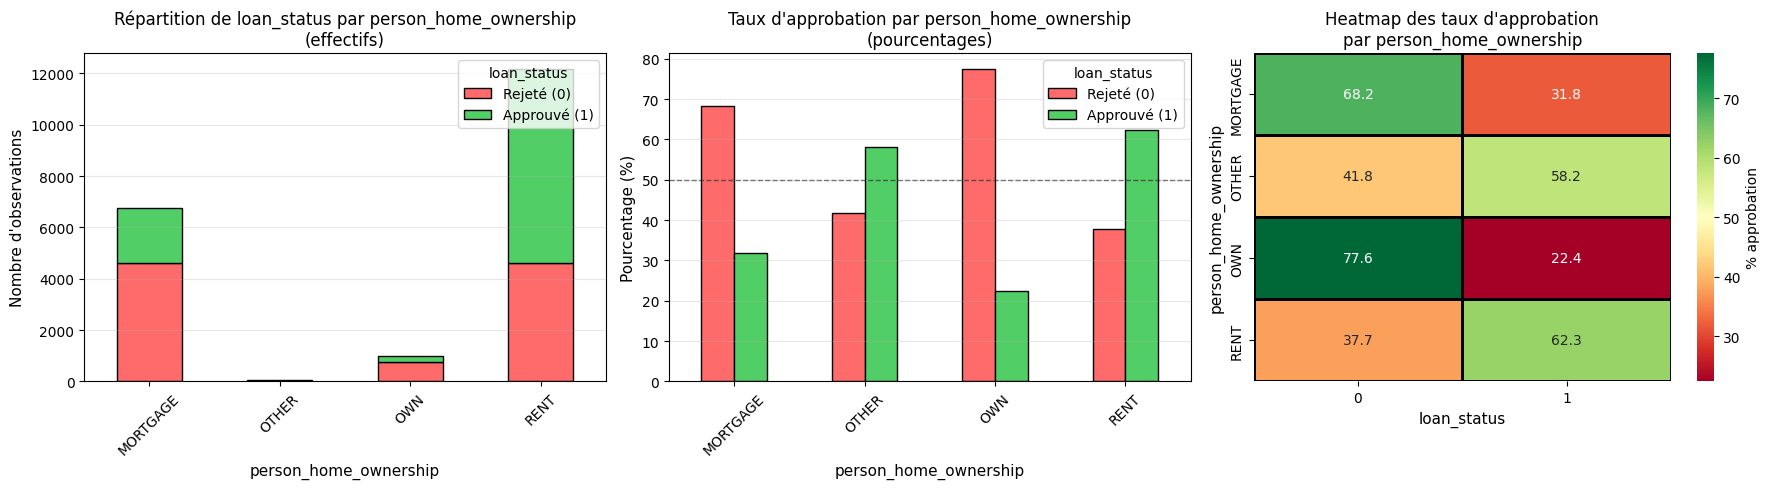


 Analyse détaillée par modalité :
────────────────────────────────────────────────────────────

  RENT :
    • Effectif total : 12193
    • Approuvés : 7595 (62.3%)
    • Rejetés : 4598 (37.7%)
     Taux d'approbation SUPÉRIEUR de 12.3% à la moyenne (50.0%)

  MORTGAGE :
    • Effectif total : 6749
    • Approuvés : 2144 (31.8%)
    • Rejetés : 4605 (68.2%)
     Taux d'approbation INFÉRIEUR de 18.2% à la moyenne (50.0%)

  OWN :
    • Effectif total : 991
    • Approuvés : 222 (22.4%)
    • Rejetés : 769 (77.6%)
     Taux d'approbation INFÉRIEUR de 27.6% à la moyenne (50.0%)

  OTHER :
    • Effectif total : 67
    • Approuvés : 39 (58.2%)
    • Rejetés : 28 (41.8%)
     Taux d'approbation SUPÉRIEUR de 8.2% à la moyenne (50.0%)

────────────────────────────────────────────────────────────────────────────────
Variable : previous_loan_defaults_on_file
────────────────────────────────────────────────────────────────────────────────

 Tableau de contingence (effectifs bruts) :
loan_status

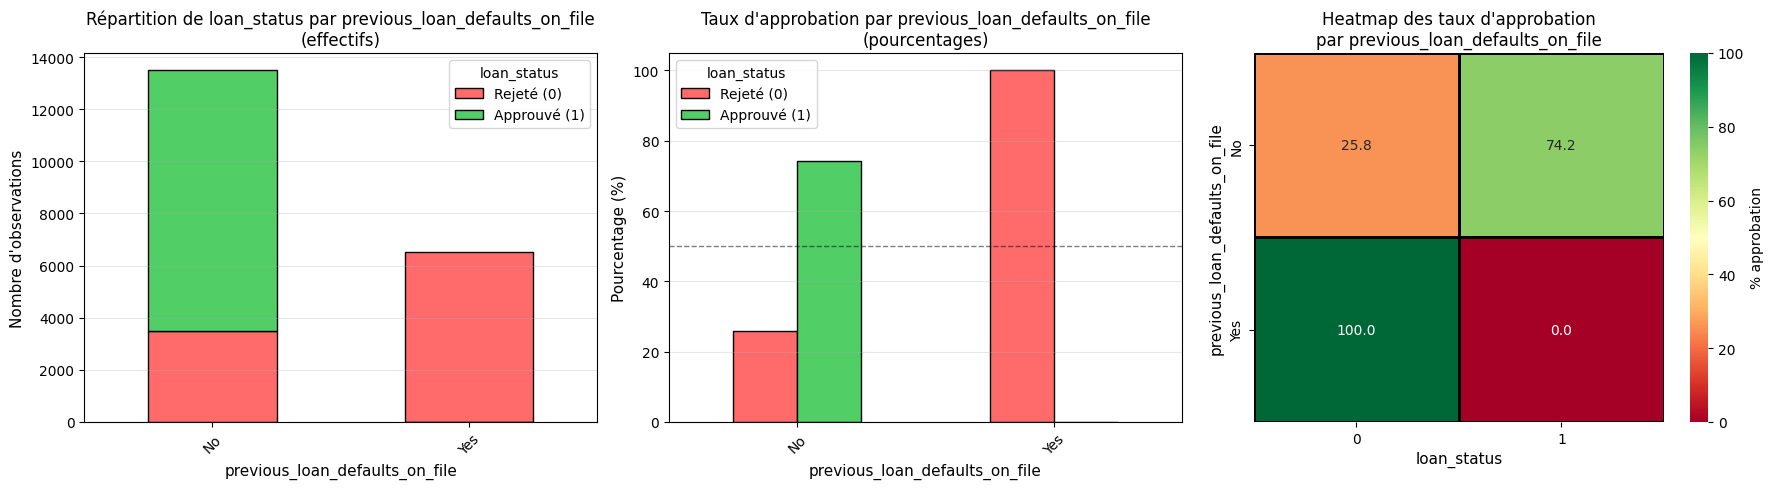


 Analyse détaillée par modalité :
────────────────────────────────────────────────────────────

  No :
    • Effectif total : 13484
    • Approuvés : 10000 (74.2%)
    • Rejetés : 3484 (25.8%)
     Taux d'approbation SUPÉRIEUR de 24.2% à la moyenne (50.0%)

  Yes :
    • Effectif total : 6516
    • Approuvés : 0 (0.0%)
    • Rejetés : 6516 (100.0%)
     Taux d'approbation INFÉRIEUR de 50.0% à la moyenne (50.0%)

────────────────────────────────────────────────────────────────────────────────
Variable : loan_intent
────────────────────────────────────────────────────────────────────────────────

 Tableau de contingence (effectifs bruts) :
loan_status            0      1    All
loan_intent                           
DEBTCONSOLIDATION   1483   2163   3646
EDUCATION           2188   1552   3740
HOMEIMPROVEMENT     1002   1258   2260
MEDICAL             1725   2378   4103
PERSONAL            1722   1521   3243
VENTURE             1880   1128   3008
All                10000  10000  20000

 

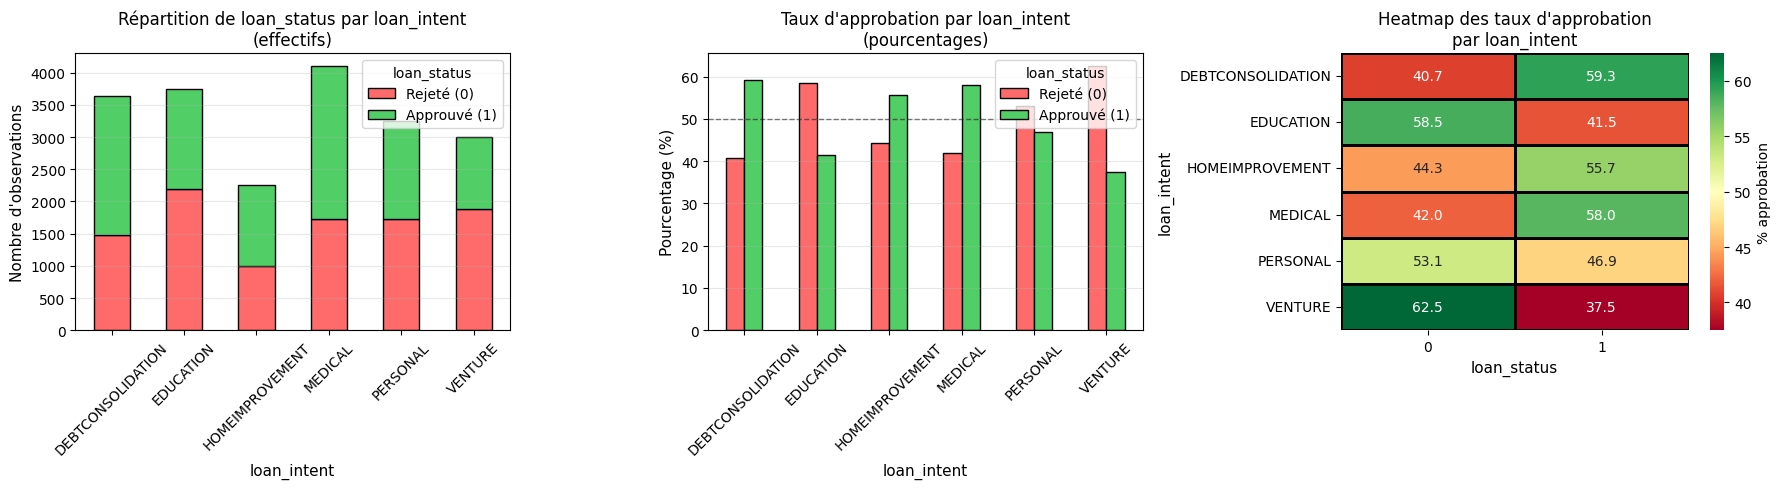


 Analyse détaillée par modalité :
────────────────────────────────────────────────────────────

  DEBTCONSOLIDATION :
    • Effectif total : 3646
    • Approuvés : 2163 (59.3%)
    • Rejetés : 1483 (40.7%)
     Taux d'approbation SUPÉRIEUR de 9.3% à la moyenne (50.0%)

  VENTURE :
    • Effectif total : 3008
    • Approuvés : 1128 (37.5%)
    • Rejetés : 1880 (62.5%)
     Taux d'approbation INFÉRIEUR de 12.5% à la moyenne (50.0%)

  EDUCATION :
    • Effectif total : 3740
    • Approuvés : 1552 (41.5%)
    • Rejetés : 2188 (58.5%)
     Taux d'approbation INFÉRIEUR de 8.5% à la moyenne (50.0%)

  MEDICAL :
    • Effectif total : 4103
    • Approuvés : 2378 (58.0%)
    • Rejetés : 1725 (42.0%)
     Taux d'approbation SUPÉRIEUR de 8.0% à la moyenne (50.0%)

  HOMEIMPROVEMENT :
    • Effectif total : 2260
    • Approuvés : 1258 (55.7%)
    • Rejetés : 1002 (44.3%)
     Taux d'approbation SUPÉRIEUR de 5.7% à la moyenne (50.0%)

  PERSONAL :
    • Effectif total : 3243
    • Approuvés : 152

In [12]:
### Analyse détaillée des variables catégorielles significatives

from scipy.stats import chi2_contingency
import warnings
warnings.filterwarnings('ignore')

# Variables catégorielles significatives identifiées
significant_categorical_vars = ['person_home_ownership', 'previous_loan_defaults_on_file', 'loan_intent']

print("="*80)
print("ANALYSE APPROFONDIE DES VARIABLES CATÉGORIELLES AVEC LOAN_STATUS")
print("="*80)

for cat_var in significant_categorical_vars:
    print(f"\n{'─'*80}")
    print(f"Variable : {cat_var}")
    print(f"{'─'*80}")
    
    # 1. Tableau de contingence
    contingency_table = pd.crosstab(df[cat_var], df['loan_status'], margins=True)
    print("\n Tableau de contingence (effectifs bruts) :")
    print(contingency_table)
    
    # 2. Tableau en pourcentages (par ligne = par modalité)
    contingency_pct = pd.crosstab(df[cat_var], df['loan_status'], normalize='index') * 100
    print("\n Répartition de loan_status par modalité (en %) :")
    print(contingency_pct.round(2))
    
    # 3. Test du Chi²
    contingency_no_margins = pd.crosstab(df[cat_var], df['loan_status'])
    chi2, p_value, dof, expected = chi2_contingency(contingency_no_margins)
    
    # Calcul du Cramér's V
    n = contingency_no_margins.sum().sum()
    min_dim = min(contingency_no_margins.shape) - 1
    cramers_v = np.sqrt(chi2 / (n * min_dim)) if min_dim > 0 else 0
    
    print(f"\n🔬 Test du Chi² :")
    print(f"  • Statistique χ² : {chi2:.2f}")
    print(f"  • Degrés de liberté : {dof}")
    print(f"  • p-value : {p_value:.4e}")
    print(f"  • Cramér's V : {cramers_v:.3f}")
    
    # Interprétation de la force
    if cramers_v >= 0.5:
        strength = "FORTE"
    elif cramers_v >= 0.3:
        strength = "MODÉRÉE"
    elif cramers_v >= 0.1:
        strength = "FAIBLE"
    else:
        strength = "NÉGLIGEABLE"
    
    print(f"  • Force de l'association : {strength}")
    print(f"  • Conclusion : {'Association SIGNIFICATIVE' if p_value < 0.05 else 'Pas d association significative'}")
    
    # 4. Visualisations
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # 4.1. Graphique en barres empilées (effectifs)
    ax1 = axes[0]
    contingency_no_margins.plot(kind='bar', stacked=True, ax=ax1, 
                                color=['#ff6b6b', '#51cf66'], edgecolor='black')
    ax1.set_title(f'Répartition de loan_status par {cat_var}\n(effectifs)', fontsize=12)
    ax1.set_xlabel(cat_var, fontsize=11)
    ax1.set_ylabel('Nombre d\'observations', fontsize=11)
    ax1.legend(title='loan_status', labels=['Rejeté (0)', 'Approuvé (1)'], loc='upper right')
    ax1.tick_params(axis='x', rotation=45)
    ax1.grid(axis='y', alpha=0.3)
    
    # 4.2. Graphique en barres groupées (pourcentages)
    ax2 = axes[1]
    contingency_pct.plot(kind='bar', ax=ax2, color=['#ff6b6b', '#51cf66'], edgecolor='black')
    ax2.set_title(f'Taux d\'approbation par {cat_var}\n(pourcentages)', fontsize=12)
    ax2.set_xlabel(cat_var, fontsize=11)
    ax2.set_ylabel('Pourcentage (%)', fontsize=11)
    ax2.legend(title='loan_status', labels=['Rejeté (0)', 'Approuvé (1)'], loc='best')
    ax2.tick_params(axis='x', rotation=45)
    ax2.axhline(y=50, color='black', linestyle='--', linewidth=1, alpha=0.5)
    ax2.grid(axis='y', alpha=0.3)
    
    # 4.3. Heatmap du tableau de contingence normalisé
    ax3 = axes[2]
    sns.heatmap(contingency_pct, annot=True, fmt='.1f', cmap='RdYlGn', 
                center=50, ax=ax3, cbar_kws={'label': '% approbation'},
                linewidths=1, linecolor='black')
    ax3.set_title(f'Heatmap des taux d\'approbation\npar {cat_var}', fontsize=12)
    ax3.set_xlabel('loan_status', fontsize=11)
    ax3.set_ylabel(cat_var, fontsize=11)
    
    plt.tight_layout()
    plt.show()
    
    # 5. Analyse détaillée par modalité
    print(f"\n Analyse détaillée par modalité :")
    print(f"{'─'*60}")
    
    for modality in df[cat_var].unique():
        subset = df[df[cat_var] == modality]
        approval_rate = (subset['loan_status'] == 1).mean() * 100
        n_obs = len(subset)
        n_approved = (subset['loan_status'] == 1).sum()
        n_rejected = (subset['loan_status'] == 0).sum()
        
        print(f"\n  {modality} :")
        print(f"    • Effectif total : {n_obs}")
        print(f"    • Approuvés : {n_approved} ({approval_rate:.1f}%)")
        print(f"    • Rejetés : {n_rejected} ({100-approval_rate:.1f}%)")
        
        # Comparaison avec la moyenne globale
        global_approval_rate = (df['loan_status'] == 1).mean() * 100
        diff = approval_rate - global_approval_rate
        
        if abs(diff) > 5:  # Seuil de 5% de différence
            if diff > 0:
                print(f"     Taux d'approbation SUPÉRIEUR de {diff:.1f}% à la moyenne ({global_approval_rate:.1f}%)")
            else:
                print(f"     Taux d'approbation INFÉRIEUR de {abs(diff):.1f}% à la moyenne ({global_approval_rate:.1f}%)")
        else:
            print(f"    ✓ Taux d'approbation proche de la moyenne ({global_approval_rate:.1f}%)")
    


In [13]:
# Prétraitement général: imputation/scale/OHE via ColumnTransformer
# construire X et y en incluant les colonnes clean
cols_keep = [c for c in df.columns if c != 'loan_status']
X = df[cols_keep].copy()
y = df['loan_status'].copy()


# Séparation des données numériques et catégorielles
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in X.columns if c not in num_cols]
print('num_cols:', num_cols)
print('cat_cols:', cat_cols)

numeric_transformer = Pipeline([('scaler', StandardScaler())])
categorical_transformer = Pipeline([('ohe', OneHotEncoder(handle_unknown='ignore'))])
preprocessor = ColumnTransformer([('num', numeric_transformer, num_cols), ('cat', categorical_transformer, cat_cols)])

# split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
print('Train/Test shapes:', X_train.shape, X_test.shape)

num_cols: ['person_age', 'person_income', 'person_emp_exp', 'loan_amnt', 'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length', 'credit_score']
cat_cols: ['person_gender', 'person_education', 'person_home_ownership', 'loan_intent', 'previous_loan_defaults_on_file']
Train/Test shapes: (16000, 13) (4000, 13)


# Modèles

## Introduction des données d'entraînement et d'évaluation

Les variables globales d'entraînement et d'évaluation sont :
* X_train, y_train
* X_test, y_test

## Dernière visualisation des données


In [ ]:
X_train

## 1. Modèles Linéraires

### Logisitic Regression

Quelques commentaires : le C apparait dans la fonction coût, le modèle réalise ici une régression linéaire classique et utilise la fonction sigmoïde pour limiter les résultats à la plage [0;1], le seuil de classification est de 0.5.


In [ ]:
# Modèle: pipeline simple avec preprocessor (sur toutes features) + LogisticRegression
pipe = Pipeline([('preprocessor', preprocessor), 
                 ('clf', LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42))])
param_grid = {'clf__C': [0.01, 0.1, 1.0, 10.0]}
gs = GridSearchCV(pipe, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=0)
gs.fit(X_train, y_train)
print('Best params:', gs.best_params_)
best = gs.best_estimator_

# évaluer sur test
y_pred = best.predict(X_test)
print('Test accuracy:', accuracy_score(y_test, y_pred))
print('\nClassification report:\n', classification_report(y_test, y_pred))


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.3.5 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/Users/amauryjanin/Library/Mobile Documents/com~apple~CloudDocs/Documents/IMT atlantique/TAF 2A/IA UE D/Projet AAA/.venv/lib/python3.11/site-packages/joblib/externals/loky/backend/popen_loky_posix.py", line 180, in <module>
    exitcode = process_obj._bootstrap()
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/

Best params: {'clf__C': 10.0}
Test accuracy: 0.873

Classification report:
               precision    recall  f1-score   support

           0       0.90      0.84      0.87      2000
           1       0.85      0.91      0.88      2000

    accuracy                           0.87      4000
   macro avg       0.88      0.87      0.87      4000
weighted avg       0.88      0.87      0.87      4000



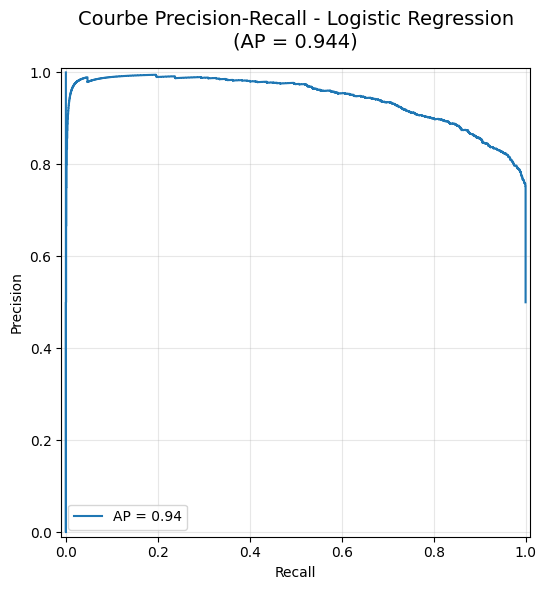

Average Precision Score: 0.9445


In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score, PrecisionRecallDisplay

# Calculer les probabilités prédites (nécessaires pour la courbe Precision-Recall)
y_proba = best.predict_proba(X_test)[:, 1]

# Calculer la courbe Precision-Recall
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
average_precision = average_precision_score(y_test, y_proba)

# Tracer la courbe Precision-Recall
fig, ax = plt.subplots(figsize=(8, 6))
display = PrecisionRecallDisplay(precision=precision, recall=recall, 
                                  average_precision=average_precision)
display.plot(ax=ax)
ax.set_title(f'Courbe Precision-Recall - Logistic Regression\n(AP = {average_precision:.3f})', 
             fontsize=14, pad=15)
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print(f'Average Precision Score: {average_precision:.4f}')



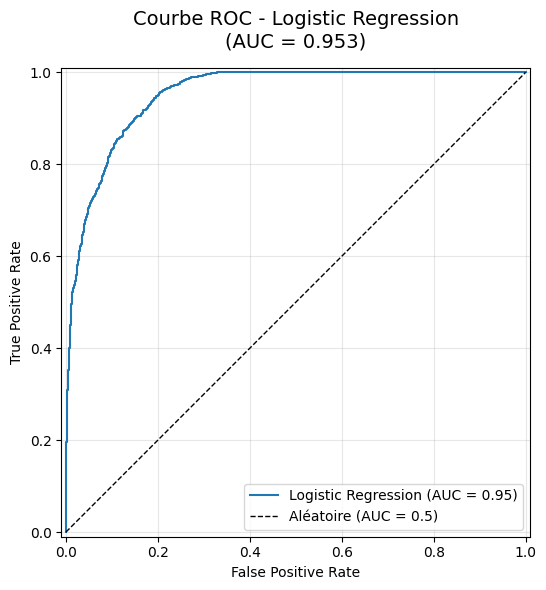

ROC AUC Score: 0.9526

 Analyse des seuils de décision (ROC):
Seuil = inf → FPR = 0.000, TPR (Recall) = 0.000
Seuil = 0.822 → FPR = 0.049, TPR (Recall) = 0.697
Seuil = 0.671 → FPR = 0.103, TPR (Recall) = 0.836
Seuil = 0.420 → FPR = 0.188, TPR (Recall) = 0.938
Seuil = 0.000 → FPR = 1.000, TPR (Recall) = 1.000


In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score, RocCurveDisplay

# Calculer la courbe ROC
fpr, tpr, roc_thresholds = roc_curve(y_test, y_proba)
roc_auc = roc_auc_score(y_test, y_proba)

# Tracer la courbe ROC
fig, ax = plt.subplots(figsize=(8, 6))
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='Logistic Regression')
display.plot(ax=ax)
ax.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Aléatoire (AUC = 0.5)')
ax.set_title(f'Courbe ROC - Logistic Regression\n(AUC = {roc_auc:.3f})', 
             fontsize=14, pad=15)
ax.grid(alpha=0.3)
ax.legend(loc='lower right')
plt.tight_layout()
plt.show()

print(f'ROC AUC Score: {roc_auc:.4f}')

# Analyser différents seuils pour la courbe ROC
print('\n Analyse des seuils de décision (ROC):')
print('='*60)
# Sélectionner quelques seuils représentatifs
roc_threshold_indices = [0, len(roc_thresholds)//4, len(roc_thresholds)//2, 3*len(roc_thresholds)//4, -1]
for idx in roc_threshold_indices:
    if idx < len(roc_thresholds):
        print(f'Seuil = {roc_thresholds[idx]:.3f} → FPR = {fpr[idx]:.3f}, TPR (Recall) = {tpr[idx]:.3f}')



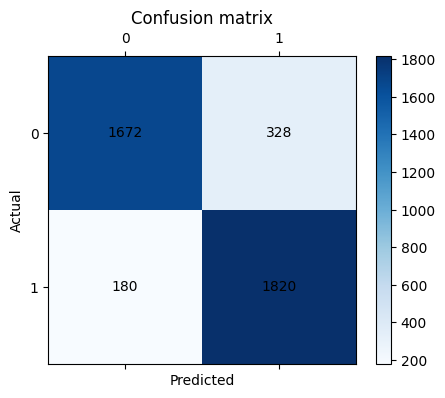

In [ ]:
# Matrice de confusion (matplotlib)
cm = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(5,4))
cax = ax.matshow(cm, cmap='Blues')
for (i, j), val in np.ndenumerate(cm):
    ax.text(j, i, int(val), ha='center', va='center', color='black')
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
labels = np.unique(y_test)
ax.set_xticks(range(len(labels)))
ax.set_yticks(range(len(labels)))
ax.set_xticklabels([str(l) for l in labels])
ax.set_yticklabels([str(l) for l in labels])
fig.colorbar(cax)
plt.title('Confusion matrix')
plt.show()

## Modélisation pour Random Forest : preprocessing et gridsearch

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Pipeline avec RandomForest
pipe_rf = Pipeline([
    ('preprocessor', preprocessor), 
    ('clf', RandomForestClassifier(random_state=42, class_weight='balanced'))
])

# GridSearch pour RandomForest
param_grid_rf = {
    'clf__n_estimators': [100, 200],
    'clf__max_depth': [10, 20, None],
    'clf__min_samples_split': [2, 5]
}

gs_rf = GridSearchCV(pipe_rf, param_grid_rf, cv=5, scoring='f1', n_jobs=-1, verbose=1)
gs_rf.fit(X_train, y_train)

print('Best params:', gs_rf.best_params_)
best_rf = gs_rf.best_estimator_

# Évaluation sur test
y_pred_rf = best_rf.predict(X_test)
print('Test accuracy:', accuracy_score(y_test, y_pred_rf))
print('\nClassification report:\n', classification_report(y_test, y_pred_rf))

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best params: {'clf__max_depth': 20, 'clf__min_samples_split': 5, 'clf__n_estimators': 200}
Test accuracy: 0.89925

Classification report:
               precision    recall  f1-score   support

           0       0.92      0.87      0.90      2000
           1       0.88      0.92      0.90      2000

    accuracy                           0.90      4000
   macro avg       0.90      0.90      0.90      4000
weighted avg       0.90      0.90      0.90      4000



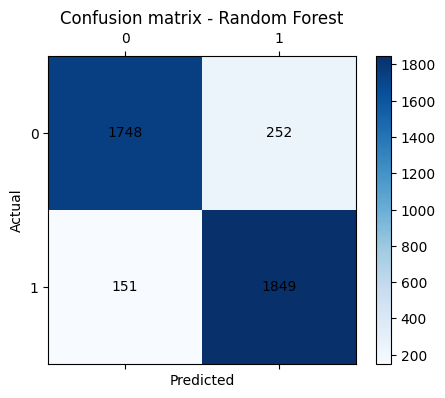

In [ ]:
# Matrice de confusion
cm_rf = confusion_matrix(y_test, y_pred_rf)
fig, ax = plt.subplots(figsize=(5,4))
cax = ax.matshow(cm_rf, cmap='Blues')
for (i, j), val in np.ndenumerate(cm_rf):
    ax.text(j, i, int(val), ha='center', va='center', color='black')
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
labels_rf = np.unique(y_test)
ax.set_xticks(range(len(labels_rf)))
ax.set_yticks(range(len(labels_rf)))
ax.set_xticklabels([str(l) for l in labels_rf])
ax.set_yticklabels([str(l) for l in labels_rf])
fig.colorbar(cax)
plt.title('Confusion matrix - Random Forest')
plt.show()

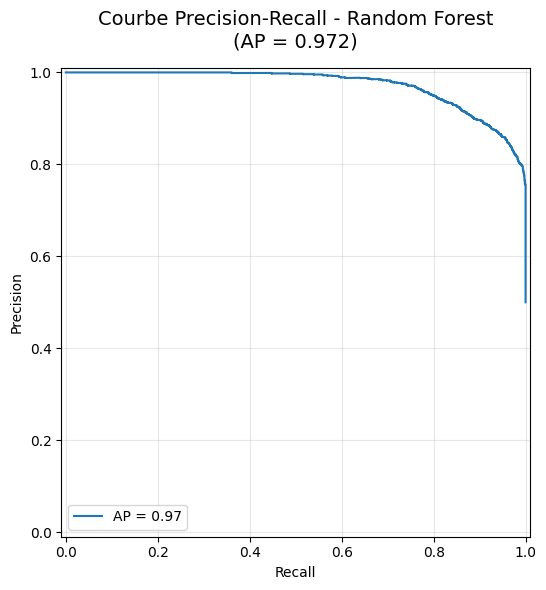

Average Precision Score: 0.9724


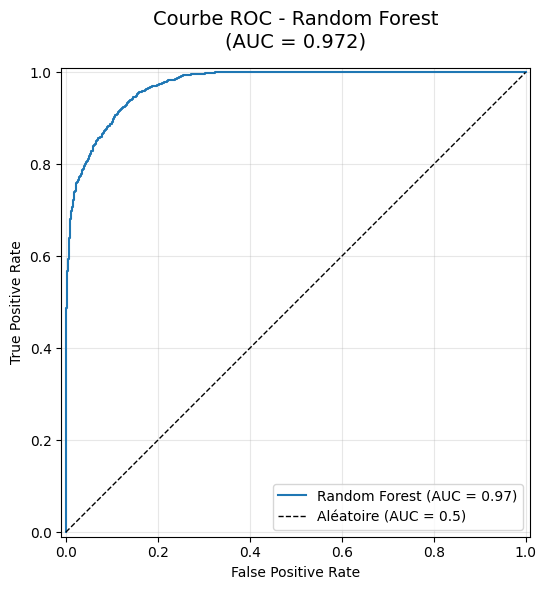


ROC AUC Score: 0.9723


In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score, PrecisionRecallDisplay
from sklearn.metrics import roc_curve, roc_auc_score, RocCurveDisplay



# Calculer les probabilités prédites
y_proba_rf = best_rf.predict_proba(X_test)[:, 1]

# Calculer la courbe Precision-Recall
precision_rf, recall_rf, thresholds_rf = precision_recall_curve(y_test, y_proba_rf)
average_precision_rf = average_precision_score(y_test, y_proba_rf)

# Tracer la courbe Precision-Recall
fig, ax = plt.subplots(figsize=(8, 6))
display = PrecisionRecallDisplay(precision=precision_rf, recall=recall_rf, 
                                  average_precision=average_precision_rf)
display.plot(ax=ax)
ax.set_title(f'Courbe Precision-Recall - Random Forest\n(AP = {average_precision_rf:.3f})', 
             fontsize=14, pad=15)
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print(f'Average Precision Score: {average_precision_rf:.4f}')



# ============================================================================
# COURBE ROC - RANDOM FOREST
# ============================================================================

# Calculer la courbe ROC
fpr_rf, tpr_rf, roc_thresholds_rf = roc_curve(y_test, y_proba_rf)
roc_auc_rf = roc_auc_score(y_test, y_proba_rf)

# Tracer la courbe ROC
fig, ax = plt.subplots(figsize=(8, 6))
display = RocCurveDisplay(fpr=fpr_rf, tpr=tpr_rf, roc_auc=roc_auc_rf, 
                          estimator_name='Random Forest')
display.plot(ax=ax)
ax.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Aléatoire (AUC = 0.5)')
ax.set_title(f'Courbe ROC - Random Forest\n(AUC = {roc_auc_rf:.3f})', 
             fontsize=14, pad=15)
ax.grid(alpha=0.3)
ax.legend(loc='lower right')
plt.tight_layout()
plt.show()

print(f'\nROC AUC Score: {roc_auc_rf:.4f}')




On observe que le recall pour l'approbation est meilleur que l'accuracy.

# Pipeline avec LightGBM

In [21]:
from lightgbm import LGBMClassifier

# Pipeline avec LightGBM (pas besoin de libomp !)
pipe_lgbm = Pipeline([
    ('preprocessor', preprocessor), 
    ('clf', LGBMClassifier(random_state=42, verbose=-1, n_jobs=1))
])

# GridSearch pour LightGBM
param_grid_lgbm = {
    'clf__n_estimators': [100, 200],
    'clf__max_depth': [5, 7, 15],
    'clf__learning_rate': [0.01, 0.1, 0.3],
    'clf__subsample': [0.8, 1.0]
}

gs_lgbm = GridSearchCV(pipe_lgbm, param_grid_lgbm, cv=5, scoring='f1', n_jobs=-1, verbose=1)
gs_lgbm.fit(X_train, y_train)

print('Best params:', gs_lgbm.best_params_)
best_lgbm = gs_lgbm.best_estimator_

# Évaluation sur test
y_pred_lgbm = best_lgbm.predict(X_test)
print('Test accuracy:', accuracy_score(y_test, y_pred_lgbm))
print('\nClassification report:\n', classification_report(y_test, y_pred_lgbm))

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best params: {'clf__learning_rate': 0.1, 'clf__max_depth': 7, 'clf__n_estimators': 200, 'clf__subsample': 0.8}
Test accuracy: 0.90675

Classification report:
               precision    recall  f1-score   support

           0       0.91      0.90      0.91      2000
           1       0.90      0.92      0.91      2000

    accuracy                           0.91      4000
   macro avg       0.91      0.91      0.91      4000
weighted avg       0.91      0.91      0.91      4000



## Pipeline avec XGBoost

In [22]:
from xgboost import XGBClassifier

# Pipeline avec XGBoost (sans restriction de thread)
pipe_xgb = Pipeline([
    ('preprocessor', preprocessor), 
    ('clf', XGBClassifier(random_state=42, eval_metric='logloss'))  # ← Retire nthread=1
])

# GridSearch avec parallélisme complet
param_grid_xgb = {
    'clf__n_estimators': [100, 200],
    'clf__max_depth': [3, 5, 7],
    'clf__learning_rate': [0.01, 0.1, 0.3],
    'clf__subsample': [0.8, 1.0]
}

# n_jobs=-1 utilise tous les cœurs CPU
gs_xgb = GridSearchCV(pipe_xgb, param_grid_xgb, cv=5, scoring='f1', n_jobs=-1, verbose=1)
gs_xgb.fit(X_train, y_train)

print('Best params:', gs_xgb.best_params_)
best_xgb = gs_xgb.best_estimator_

# Évaluation sur test
y_pred_xgb = best_xgb.predict(X_test)
print('Test accuracy:', accuracy_score(y_test, y_pred_xgb))
print('\nClassification report:\n', classification_report(y_test, y_pred_xgb))

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best params: {'clf__learning_rate': 0.3, 'clf__max_depth': 3, 'clf__n_estimators': 200, 'clf__subsample': 1.0}
Test accuracy: 0.906

Classification report:
               precision    recall  f1-score   support

           0       0.92      0.89      0.90      2000
           1       0.89      0.92      0.91      2000

    accuracy                           0.91      4000
   macro avg       0.91      0.91      0.91      4000
weighted avg       0.91      0.91      0.91      4000



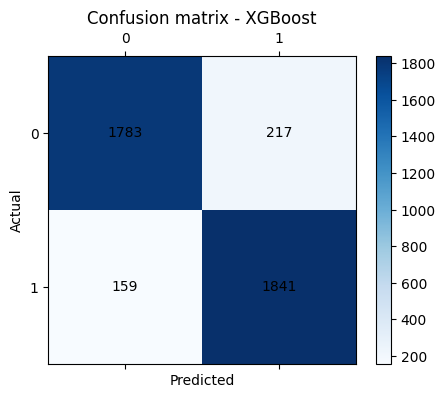

In [23]:
# Matrice de confusion
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
fig, ax = plt.subplots(figsize=(5,4))
cax = ax.matshow(cm_xgb, cmap='Blues')
for (i, j), val in np.ndenumerate(cm_xgb):
    ax.text(j, i, int(val), ha='center', va='center', color='black')
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
labels_xgb = np.unique(y_test)
ax.set_xticks(range(len(labels_xgb)))
ax.set_yticks(range(len(labels_xgb)))
ax.set_xticklabels([str(l) for l in labels_xgb])
ax.set_yticklabels([str(l) for l in labels_xgb])
fig.colorbar(cax)
plt.title('Confusion matrix - XGBoost')
plt.show()

# Réseau de neurones (PyTorch)
Dans cette section, nous construisons un réseau de neurones entièrement connecté (*Multi-Layer Perceptron*) en utilisant PyTorch, afin de proposer une alternative plus flexible aux modèles classiques (Logistic Regression, SVM, KNN, etc.).

Métiel du pipeline :
- **GELU** : une activation plus performante que ReLU pour les réseaux profonds.  
- **Batch Normalization** : stabilise et accélère l'entraînement.  
- **Dropout** : régularisation légère pour réduire le surapprentissage.  
- **Skip Connection (résiduelle)** : améliore la propagation du gradient.  
- **Projection du skip** : permet d'additionner des tenseurs de dimensions différentes (128 → 64).  
- **Initialisation Kaiming/He** : adaptée aux activations GELU/LeakyReLU.  
- **Gradient Clipping** : évite l'exploding gradient.  
- **OneCycleLR** : scheduler moderne permettant une convergence plus rapide et plus stable.  
- **Early Stopping** : arrête l'entraînement dès que la perte ne s'améliore plus.


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# -------------------------------------------------------------------
# Préparation des données : conversion explicite en valeurs numériques
# -------------------------------------------------------------------
# PyTorch ne gère pas les types "object" : on force tous les champs à devenir numériques.
X_train = X_train.apply(pd.to_numeric, errors="coerce").fillna(0).astype(np.float32)
X_test  = X_test.apply(pd.to_numeric, errors="coerce").fillna(0).astype(np.float32)

# Conversion en tenseurs PyTorch
X_train_t = torch.tensor(X_train.values, dtype=torch.float32)
X_test_t  = torch.tensor(X_test.values, dtype=torch.float32)
y_train_t = torch.tensor(y_train.values, dtype=torch.long)
y_test_t  = torch.tensor(y_test.values, dtype=torch.long)

# Création du DataLoader pour gérer les batches
train_dataset = TensorDataset(X_train_t, y_train_t)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)


class DeepMLP(nn.Module):
    def __init__(self, input_dim):
        super().__init__()

        # Premier bloc dense
        self.layer1 = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.BatchNorm1d(128),
            nn.GELU(),
            nn.Dropout(0.1)
        )

        # Deuxième bloc dense
        self.layer2 = nn.Sequential(
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.GELU(),
            nn.Dropout(0.1)
        )

        # Projection du skip (128 vers 64)
        self.skip_proj = nn.Linear(128, 64)

        # Couche de sortie
        self.output = nn.Linear(64, 2)

        # Initialisation He/Kaiming
        self.apply(self._init_weights)

    def _init_weights(self, layer):
        if isinstance(layer, nn.Linear):
            nn.init.kaiming_uniform_(layer.weight, nonlinearity="leaky_relu")
            nn.init.zeros_(layer.bias)

    def forward(self, x):
        x = self.layer1(x)
        skip = self.skip_proj(x)
        x = self.layer2(x) + skip
        return self.output(x)

# Instanciation du modèle
mlp = DeepMLP(X_train.shape[1])

# -------------------------------------------------------------------
# Configuration de l'entraînement
# -------------------------------------------------------------------

optimizer = optim.Adam(mlp.parameters(), lr=0.001)

# Scheduler OneCycleLR pour améliorer la convergence
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=0.01,
    steps_per_epoch=len(train_loader),
    epochs=20
)

criterion = nn.CrossEntropyLoss()

# Early stopping
best_loss = float("inf")
patience = 4
counter = 0

# -------------------------------------------------------------------
# Boucle d'entraînement
# -------------------------------------------------------------------
EPOCHS = 20
for epoch in range(EPOCHS):
    mlp.train()
    epoch_loss = 0

    for xb, yb in train_loader:
        optimizer.zero_grad()

        preds = mlp(xb)
        loss = criterion(preds, yb)
        loss.backward()

        # Coupe les gradients trop grands
        nn.utils.clip_grad_norm_(mlp.parameters(), max_norm=1.0)

        optimizer.step()
        scheduler.step()

        epoch_loss += loss.item()

    print(f"Epoch {epoch+1}/{EPOCHS} — Loss: {epoch_loss/len(train_loader):.4f}")

    # Early stopping basé sur la perte d'entraînement
    if epoch_loss < best_loss:
        best_loss = epoch_loss
        counter = 0
        best_model_state = mlp.state_dict()
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping déclenché.")
            break

# Chargement du meilleur modèle sauvegardé
mlp.load_state_dict(best_model_state)

# -------------------------------------------------------------------
# Évaluation finale
# -------------------------------------------------------------------
mlp.eval()
with torch.no_grad():
    preds_test = mlp(X_test_t).argmax(1).numpy()

print("\nPerformance du réseau de neurones :")
print("Accuracy:", accuracy_score(y_test, preds_test))
print("\nMatrice de confusion:\n", confusion_matrix(y_test, preds_test))
print("\nRapport de classification:\n", classification_report(y_test, preds_test))


In [ ]:
## 1. Récapitulatif des hyperparamètres testés et résultats

# Afficher les meilleurs hyperparamètres pour chaque modèle
models_info = {
    'Logistic Regression': {
        'best_params': gs.best_params_,
        'best_score': gs.best_score_,
        'cv_results': gs.cv_results_,
        'model': best
    },
    'Random Forest': {
        'best_params': gs_rf.best_params_,
        'best_score': gs_rf.best_score_,
        'cv_results': gs_rf.cv_results_,
        'model': best_rf
    },
    'LightGBM': {
        'best_params': gs_lgbm.best_params_,
        'best_score': gs_lgbm.best_score_,
        'cv_results': gs_lgbm.cv_results_,
        'model': best_lgbm
    },
    'XGBoost': {
        'best_params': gs_xgb.best_params_,
        'best_score': gs_xgb.best_score_,
        'cv_results': gs_xgb.cv_results_,
        'model': best_xgb
    }
}

_, X_test_clean, _, y_test_clean = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


X_test_clean[cat_cols] = X_test_clean[cat_cols].fillna("Missing")
X_test_clean[num_cols] = X_test_clean[num_cols].fillna(0)


print("="*80)
print("RÉSUMÉ DES MEILLEURS HYPERPARAMÈTRES PAR MODÈLE")
print("="*80)

for model_name, info in models_info.items():
    print(f"\n{'─'*80}")
    print(f" {model_name}")
    print(f"{'─'*80}")
    print(f"Meilleur F1-score (validation croisée) : {info['best_score']:.4f}")
    print(f"\nMeilleurs hyperparamètres :")
    for param, value in info['best_params'].items():
        print(f"  • {param}: {value}")
    
    # Évaluation sur l'ensemble de test
    y_pred_temp = info['model'].predict(X_test_clean)
    from sklearn.metrics import f1_score, precision_score, recall_score
    f1 = f1_score(y_test, y_pred_temp)
    precision = precision_score(y_test, y_pred_temp)
    recall = recall_score(y_test, y_pred_temp)
    accuracy = accuracy_score(y_test, y_pred_temp)
    
    print(f"\nMétriques sur l'ensemble de test :")
    print(f"  • F1-score     : {f1:.4f}")
    print(f"  • Précision    : {precision:.4f}")
    print(f"  • Recall       : {recall:.4f}")
    print(f"  • Accuracy     : {accuracy:.4f}")

In [ ]:
## 2. Analyse détaillée de l'impact des hyperparamètres pour Logistic Regression

print("\n" + "="*80)
print("ANALYSE DÉTAILLÉE : LOGISTIC REGRESSION")
print("="*80)

# Extraire les résultats de la grille
cv_results_lr = pd.DataFrame(gs.cv_results_)
print(f"\nNombre de combinaisons testées : {len(cv_results_lr)}")
print(f"\nColonnes principales :")
cols_to_show = [col for col in cv_results_lr.columns if 'param_' in col or 'mean_test' in col]
print(cv_results_lr[cols_to_show].to_string())

# Visualiser l'impact du paramètre C
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1 : Score en fonction de C
ax1 = axes[0]
c_values = cv_results_lr['param_clf__C'].values
mean_test_scores = cv_results_lr['mean_test_score'].values
std_test_scores = cv_results_lr['std_test_score'].values

ax1.plot(range(len(c_values)), mean_test_scores, 'o-', linewidth=2, markersize=8, label='Mean F1-score')
ax1.fill_between(range(len(c_values)), 
                  mean_test_scores - std_test_scores,
                  mean_test_scores + std_test_scores,
                  alpha=0.3, label='±1 Std Dev')
ax1.set_xlabel('Index des combinaisons (ordonnées par C croissant)')
ax1.set_ylabel('F1-score (validation croisée)')
ax1.set_title('Logistic Regression : Impact du paramètre C')
ax1.set_xticks(range(len(c_values)))
ax1.set_xticklabels([f'{c:.2f}' for c in c_values], rotation=45)
ax1.grid(alpha=0.3)
ax1.legend()

# Plot 2 : Courbe de performance en fonction de C (log scale)
ax2 = axes[1]
ax2.semilogx(c_values, mean_test_scores, 'o-', linewidth=2, markersize=8, label='Mean F1-score')
ax2.fill_between(c_values, 
                  mean_test_scores - std_test_scores,
                  mean_test_scores + std_test_scores,
                  alpha=0.3, label='±1 Std Dev')
ax2.set_xlabel('Paramètre C (échelle logarithmique)')
ax2.set_ylabel('F1-score (validation croisée)')
ax2.set_title('Logistic Regression : C vs F1-score')
ax2.grid(alpha=0.3, which='both')
ax2.legend()

# Marquer le meilleur point
best_idx = cv_results_lr['rank_test_score'].argmin()
ax2.plot(cv_results_lr.loc[best_idx, 'param_clf__C'], 
         cv_results_lr.loc[best_idx, 'mean_test_score'],
         'r*', markersize=20, label='Meilleur')

plt.tight_layout()
plt.show()

print(f"\n📈 Observations :")
print(f"  • Meilleur C : {cv_results_lr.loc[best_idx, 'param_clf__C']}")
print(f"  • Meilleur F1-score : {cv_results_lr.loc[best_idx, 'mean_test_score']:.4f}")
print(f"  • Écart-type : {cv_results_lr.loc[best_idx, 'std_test_score']:.4f}")


In [ ]:
## 3. Analyse détaillée de l'impact des hyperparamètres pour Random Forest

print("\n" + "="*80)
print("ANALYSE DÉTAILLÉE : RANDOM FOREST")
print("="*80)

# Extraire les résultats de la grille
cv_results_rf = pd.DataFrame(gs_rf.cv_results_)
print(f"\nNombre de combinaisons testées : {len(cv_results_rf)}")

# Afficher le tableau complet des résultats
cols_to_show = [col for col in cv_results_rf.columns if 'param_' in col or 'mean_test' in col]
print("\n📊 Résultats de la validation croisée :")
print(cv_results_rf[cols_to_show].to_string())

# Analyser l'impact de chaque hyperparamètre séparément
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Gérer les valeurs None en les séparant
max_depths = sorted([x for x in cv_results_rf['param_clf__max_depth'].unique() if x is not None]) + [None]
min_splits = sorted(cv_results_rf['param_clf__min_samples_split'].unique())
n_ests = sorted(cv_results_rf['param_clf__n_estimators'].unique())

# 1. Impact de n_estimators
ax1 = axes[0, 0]
for max_depth in max_depths:
    for min_samples_split in min_splits:
        mask = (cv_results_rf['param_clf__max_depth'] == max_depth) & \
               (cv_results_rf['param_clf__min_samples_split'] == min_samples_split)
        data = cv_results_rf[mask].sort_values('param_clf__n_estimators')
        if len(data) > 0:
            label = f'max_depth={max_depth}, min_samples_split={min_samples_split}'
            ax1.plot(data['param_clf__n_estimators'], data['mean_test_score'], 'o-', label=label)

ax1.set_xlabel('n_estimators (nombre d\'arbres)')
ax1.set_ylabel('F1-score (validation croisée)')
ax1.set_title('Random Forest : Impact de n_estimators')
ax1.legend(fontsize=8)
ax1.grid(alpha=0.3)

# 2. Impact de max_depth
ax2 = axes[0, 1]
for n_est in n_ests:
    for min_samples_split in min_splits:
        mask = (cv_results_rf['param_clf__n_estimators'] == n_est) & \
               (cv_results_rf['param_clf__min_samples_split'] == min_samples_split)
        data = cv_results_rf[mask].copy()
        if len(data) > 0:
            # Trier avec None à la fin
            data['max_depth_sort'] = data['param_clf__max_depth'].apply(lambda x: float('inf') if x is None else x)
            data = data.sort_values('max_depth_sort')
            label = f'n_estimators={n_est}, min_samples_split={min_samples_split}'
            max_d_vals = [str(d) if d is not None else 'None' for d in data['param_clf__max_depth']]
            ax2.plot(range(len(max_d_vals)), data['mean_test_score'].values, 'o-', label=label)

ax2.set_xlabel('max_depth')
ax2.set_ylabel('F1-score (validation croisée)')
ax2.set_title('Random Forest : Impact de max_depth')
ax2.legend(fontsize=8)
ax2.grid(alpha=0.3)

# 3. Impact de min_samples_split
ax3 = axes[1, 0]
for n_est in n_ests:
    for max_depth in max_depths:
        mask = (cv_results_rf['param_clf__n_estimators'] == n_est) & \
               (cv_results_rf['param_clf__max_depth'] == max_depth)
        data = cv_results_rf[mask].sort_values('param_clf__min_samples_split')
        if len(data) > 0:
            label = f'n_estimators={n_est}, max_depth={max_depth}'
            ax3.plot(data['param_clf__min_samples_split'], data['mean_test_score'], 'o-', label=label)

ax3.set_xlabel('min_samples_split')
ax3.set_ylabel('F1-score (validation croisée)')
ax3.set_title('Random Forest : Impact de min_samples_split')
ax3.legend(fontsize=8)
ax3.grid(alpha=0.3)

# 4. Heatmap de performance (n_estimators vs max_depth, pour min_samples_split=2)
ax4 = axes[1, 1]
mask_subset = cv_results_rf['param_clf__min_samples_split'] == 2
subset_data = cv_results_rf[mask_subset].copy()
if len(subset_data) > 0:
    # Convertir None en string pour la création du pivot_table
    subset_data['max_depth_label'] = subset_data['param_clf__max_depth'].apply(lambda x: 'None' if x is None else str(int(x)))
    subset_pivot = subset_data.pivot_table(
        values='mean_test_score',
        index='max_depth_label',
        columns='param_clf__n_estimators'
    )
    im = ax4.imshow(subset_pivot.values, cmap='viridis', aspect='auto')
    ax4.set_xticks(range(len(subset_pivot.columns)))
    ax4.set_yticks(range(len(subset_pivot.index)))
    ax4.set_xticklabels(subset_pivot.columns)
    ax4.set_yticklabels(subset_pivot.index)
    ax4.set_xlabel('n_estimators')
    ax4.set_ylabel('max_depth')
    ax4.set_title('Heatmap : F1-score (min_samples_split=2)')
    for i in range(len(subset_pivot.index)):
        for j in range(len(subset_pivot.columns)):
            val = subset_pivot.values[i, j]
            if not np.isnan(val):
                text = ax4.text(j, i, f'{val:.3f}',
                               ha="center", va="center", color="w", fontsize=9)
    plt.colorbar(im, ax=ax4)
else:
    ax4.text(0.5, 0.5, 'Pas de données pour cette combinaison', ha='center', va='center')

plt.tight_layout()
plt.show()

# Meilleur modèle
best_idx_rf = cv_results_rf['rank_test_score'].argmin()
print(f"\n📈 Meilleure configuration :")
print(f"  • n_estimators : {cv_results_rf.loc[best_idx_rf, 'param_clf__n_estimators']}")
print(f"  • max_depth : {cv_results_rf.loc[best_idx_rf, 'param_clf__max_depth']}")
print(f"  • min_samples_split : {cv_results_rf.loc[best_idx_rf, 'param_clf__min_samples_split']}")
print(f"  • F1-score : {cv_results_rf.loc[best_idx_rf, 'mean_test_score']:.4f}")


In [ ]:
## 4. Analyse détaillée de l'impact des hyperparamètres pour XGBoost


# Extraire les résultats
cv_results_xgb = pd.DataFrame(gs_xgb.cv_results_)
print(f"\nNombre de combinaisons testées : {len(cv_results_xgb)}")

# Tableau des résultats
cols_to_show = [col for col in cv_results_xgb.columns if 'param_' in col or 'mean_test' in col]
print("\n Résultats de la validation croisée :")
print(cv_results_xgb[cols_to_show].sort_values('mean_test_score', ascending=False).head(10).to_string())

# Visualisations pour XGBoost
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Récupérer les valeurs uniques triées
learning_rates = sorted(cv_results_xgb['param_clf__learning_rate'].unique())
max_depths_xgb = sorted(cv_results_xgb['param_clf__max_depth'].unique())
n_ests_xgb = sorted(cv_results_xgb['param_clf__n_estimators'].unique())
subsamples = sorted(cv_results_xgb['param_clf__subsample'].unique())

# 1. Impact de n_estimators
ax1 = axes[0, 0]
for learning_rate in learning_rates:
    for max_depth in max_depths_xgb:
        mask = (cv_results_xgb['param_clf__learning_rate'] == learning_rate) & \
               (cv_results_xgb['param_clf__max_depth'] == max_depth)
        data = cv_results_xgb[mask].sort_values('param_clf__n_estimators')
        if len(data) > 0:
            label = f'lr={learning_rate}, max_depth={max_depth}'
            ax1.plot(data['param_clf__n_estimators'], data['mean_test_score'], 'o-', label=label)

ax1.set_xlabel('n_estimators')
ax1.set_ylabel('F1-score')
ax1.set_title('XGBoost : Impact de n_estimators')
ax1.legend(fontsize=8)
ax1.grid(alpha=0.3)

# 2. Impact de learning_rate
ax2 = axes[0, 1]
for max_depth in max_depths_xgb:
    for n_est in n_ests_xgb:
        mask = (cv_results_xgb['param_clf__max_depth'] == max_depth) & \
               (cv_results_xgb['param_clf__n_estimators'] == n_est)
        data = cv_results_xgb[mask].sort_values('param_clf__learning_rate')
        if len(data) > 0:
            label = f'max_depth={max_depth}, n_est={n_est}'
            ax2.plot(data['param_clf__learning_rate'], data['mean_test_score'], 'o-', label=label)

ax2.set_xlabel('learning_rate')
ax2.set_ylabel('F1-score')
ax2.set_title('XGBoost : Impact du learning_rate')
ax2.legend(fontsize=8)
ax2.grid(alpha=0.3)

# 3. Impact de max_depth
ax3 = axes[1, 0]
for learning_rate in learning_rates:
    for n_est in n_ests_xgb:
        mask = (cv_results_xgb['param_clf__learning_rate'] == learning_rate) & \
               (cv_results_xgb['param_clf__n_estimators'] == n_est)
        data = cv_results_xgb[mask].sort_values('param_clf__max_depth')
        if len(data) > 0:
            label = f'lr={learning_rate}, n_est={n_est}'
            ax3.plot(data['param_clf__max_depth'], data['mean_test_score'], 'o-', label=label)

ax3.set_xlabel('max_depth')
ax3.set_ylabel('F1-score')
ax3.set_title('XGBoost : Impact de max_depth')
ax3.legend(fontsize=8)
ax3.grid(alpha=0.3)

# 4. Heatmap learning_rate vs max_depth (n_estimators=100, subsample=1.0)
ax4 = axes[1, 1]
mask_subset = (cv_results_xgb['param_clf__n_estimators'] == 100) & \
              (cv_results_xgb['param_clf__subsample'] == 1.0)
subset_data = cv_results_xgb[mask_subset].copy()
if len(subset_data) > 0:
    # Convertir learning_rate et max_depth pour pivot
    subset_data['learning_rate_label'] = subset_data['param_clf__learning_rate'].astype(str)
    subset_data['max_depth_label'] = subset_data['param_clf__max_depth'].astype(str)
    subset_pivot = subset_data.pivot_table(
        values='mean_test_score',
        index='max_depth_label',
        columns='learning_rate_label'
    )
    if subset_pivot.notna().sum().sum() > 0:
        im = ax4.imshow(subset_pivot.values, cmap='viridis', aspect='auto')
        ax4.set_xticks(range(len(subset_pivot.columns)))
        ax4.set_yticks(range(len(subset_pivot.index)))
        ax4.set_xticklabels([f'{x:.2f}' for x in [float(col) for col in subset_pivot.columns]])
        ax4.set_yticklabels(subset_pivot.index)
        ax4.set_xlabel('learning_rate')
        ax4.set_ylabel('max_depth')
        ax4.set_title('Heatmap : F1-score (n_est=100, subsample=1.0)')
        for i in range(len(subset_pivot.index)):
            for j in range(len(subset_pivot.columns)):
                val = subset_pivot.values[i, j]
                if not np.isnan(val):
                    text = ax4.text(j, i, f'{val:.3f}',
                                   ha="center", va="center", color="w", fontsize=9)
        plt.colorbar(im, ax=ax4)
    else:
        ax4.text(0.5, 0.5, 'Pas assez de données', ha='center', va='center')
else:
    ax4.text(0.5, 0.5, 'Pas de données pour cette combinaison', ha='center', va='center')

plt.tight_layout()
plt.show()

best_idx_xgb = cv_results_xgb['mean_test_score'].idxmax()
print(f"\n Meilleure configuration :")
print(f"  • n_estimators : {cv_results_xgb.loc[best_idx_xgb, 'param_clf__n_estimators']}")
print(f"  • max_depth : {cv_results_xgb.loc[best_idx_xgb, 'param_clf__max_depth']}")
print(f"  • learning_rate : {cv_results_xgb.loc[best_idx_xgb, 'param_clf__learning_rate']}")
print(f"  • subsample : {cv_results_xgb.loc[best_idx_xgb, 'param_clf__subsample']}")
print(f"  • F1-score : {cv_results_xgb.loc[best_idx_xgb, 'mean_test_score']:.4f}")
